In [2]:
import re
import string
import json
import os
import glob
import shutil
from pprint import pprint
from functools import partial

import joblib
import matplotlib.pyplot as plt
import nltk
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import sacremoses
from sklearn.base import clone
from sklearn.compose import (
    ColumnTransformer,
    make_column_selector,
    make_column_transformer,
)
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    classification_report,
)


# Set Seaborn theme and default palette
sns.set_theme(font_scale=1.25, style="darkgrid")
sns.set_palette("deep", desat=0.85, color_codes=True)

# Turn on inline plotting
%matplotlib inline

# Load Black auto-formatter
%load_ext nb_black

<IPython.core.display.Javascript object>

In [3]:
# Import my modules
from tools import cleaning, plotting, language as lang, outliers, utils
from tools.sklearn import selection

RUN_LANGDETECT = False

# Run time-consuming grid searches
RUN_SWEEPS = frozenset()

FIT_MODELS = frozenset()

# Set my default MPL settings
plt.rcParams.update(plotting.MPL_DEFAULTS)

# Enable automatic reloading
%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>

# Preparing the Data

In [3]:
df = pd.read_parquet(
    "data/amazon_clean",
    engine="pyarrow",
    columns=[
        "text",
        "title",
        "brand",
        "main_cat",
    ],
)

df

text  \
asin                                                            
1441072241  come tell me how you lived: native american hi...   
6090113980  prayer rug carpet mat gebetsteppich islamic mu...   
7250468162  no7 stay perfect foundation cool vanilla by no...   
8279996397  imagen bendita por su santidad our lady of cha...   
9197882747  hall of femmes: lella vignelli (hall of femmes...   
...                                                       ...   
B01HHFHGES  xiaokong women's high low hem sleeveless flora...   
B01HHX5AF2  duxa women's working my adipose off symbol gra...   
B01HHZYKYW  aliixun2 unisex the 2016 rio de janeiro olympi...   
B01HIUH2AK  busoni : konzertstuck fur klavier mit orcheste...   
B01HIXTMKA  thin red line flag bling baseball cap distress...   

                                                        title  \
asin                                                            
1441072241  come tell me how you lived: native american hi...   
6090113980  prayer rug carpet mat gebetsteppich islamic mu...   
7250468162    no7 stay perfect foundation cool vanilla by no7   
8279996397  imagen bendita por su santidad our lady of cha...   
9197882747    hall of femmes: lella vignelli (hall of femmes)   
...                                                       ...   
B01HHFHGES  xiaokong women's high low hem sleeveless flora...   
B01HHX5AF2  duxa women's working my adipose off symbol gra...   
B01HHZYKYW  aliixun2 unisex the 2016 rio de janeiro olympi...   
B01HIUH2AK    busoni : konzertstuck fur klavier mit orchester   
B01HIXTMKA  thin red line flag bling baseball cap distress...   

                       brand    main_cat  
asin                                      
1441072241   enter the arena  all beauty  
6090113980        bonballoon  all beauty  
7250468162               no7  all beauty  
8279996397            chango  all beauty  
9197882747      oyster press  all beauty  
...                      ...         ...  
B01HHFHGES          xiaokong       books  
B01HHX5AF2              duxa       books  
B01HHZYKYW          aliixun2       books  
B01HIUH2AK  ferruccio busoni       books  
B01HIXTMKA           elivata       books  

[3679356 rows x 4 columns]

<IPython.core.display.Javascript object>

In [4]:
cleaning.info(df)

null  null_%     uniq  uniq_%  dup  dup_%
text         0     0.0  3679356  100.00    0    0.0
title        0     0.0  3659460   99.46    0    0.0
brand        0     0.0   817732   22.22    0    0.0
main_cat     0     0.0       36    0.00    0    0.0

<IPython.core.display.Javascript object>

The classes are very imbalanced, and books are unsurprisingly at the top. Amazon started as a bookstore, after all.

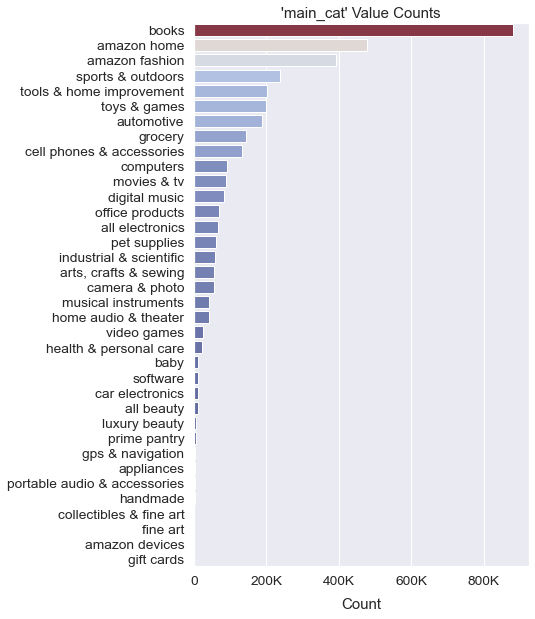

<IPython.core.display.Javascript object>

In [5]:
ax = plotting.plots.countplot(df.loc[:, "main_cat"], size=(6, 10))
ax.xaxis.set_major_formatter(plotting.big_number_formatter())

## Refining the Brands

I begin with the brand terms, which will be very important for the classifier.

In [6]:
empty_brand = df.loc[df.brand.str.fullmatch("\s*")]
empty_brand

text  \
asin                                                            
B000050B67  norelco 5655x deluxe advantage wet/dry cordles...   
B000050B69  norelco t7500 deluxe cord/cordless rechargeabl...   
B000050FDP  braun 6520 flex integral ultra speed rechargea...   
B000052YD8  scope original mint mouthwash 50.7 fl oz. scop...   
B00005336W  dove nutrium nutrient beads nourishing body wa...   
...                                                       ...   
B01H0UDFXQ  marc lawrence's 2016 playbook football preview...   
B01H3U5GNA  american original soft and cozy coastal stripe...   
B01H87P6YM  hitachi 43in 2160p 120hz 4k uhd led tv. the ne...   
B01HB59462  hanging chaise lounger chair arc stand air por...   
B01HCAUSG6  elizabeth jane howard cazalet chronicles 5 boo...   

                                                        title brand  \
asin                                                                  
B000050B67  norelco 5655x deluxe advantage wet/dry cordles...         
B000050B69  norelco t7500 deluxe cord/cordless rechargeabl...         
B000050FDP  braun 6520 flex integral ultra speed rechargea...         
B000052YD8           scope original mint mouthwash 50.7 fl oz         
B00005336W  dove nutrium nutrient beads nourishing body wa...         
...                                                       ...   ...   
B01H0UDFXQ     marc lawrence's 2016 playbook football preview         
B01H3U5GNA  american original soft and cozy coastal stripe...         
B01H87P6YM             hitachi 43in 2160p 120hz 4k uhd led tv         
B01HB59462  hanging chaise lounger chair arc stand air por...         
B01HCAUSG6  elizabeth jane howard cazalet chronicles 5 boo...         

              main_cat  
asin                    
B000050B67  all beauty  
B000050B69  all beauty  
B000050FDP  all beauty  
B000052YD8  all beauty  
B00005336W  all beauty  
...                ...  
B01H0UDFXQ       books  
B01H3U5GNA       books  
B01H87P6YM       books  
B01HB59462       books  
B01HCAUSG6       books  

[146476 rows x 4 columns]

<IPython.core.display.Javascript object>

Looks like there are over about 1.6 million empty brand entries. I'll replace those with 'none' for now.

In [7]:
df.loc[empty_brand.index, "brand"] = "none"
df.loc[df.brand.str.fullmatch("\s*")]

Empty DataFrame
Columns: [text, title, brand, main_cat]
Index: []

<IPython.core.display.Javascript object>

In [8]:
del empty_brand

<IPython.core.display.Javascript object>

Next, I'm going to tokenize the brands using the default Scikit-Learn tokenizer regex (r'\b\w\w+\b'). This is the default value for 'token_pattern' in `CountVectorizer`, `HashingVectorizer`, and `TfidfVectorizer`.

I like the default Scikit-Learn tokenizer because it ignores punctuation and grabs sequences of 2 or more word characters (within word boundaries). It strips out most of the noise in a single stroke.

I define a function below using this pattern.

In [9]:
def sklearn_tokenize(docs, n_jobs=None):
    pattern = re.compile(r"\b\w\w+\b")
    return lang.process_strings(docs, pattern.findall, n_jobs=n_jobs)

<IPython.core.display.Javascript object>

It's a short function, but a powerful one. It's **polymorphic**, meaning that it it behaves differently depending on the input type. If `docs` is a string, it simply returns the list of tokens. However, if `docs` is a container type like `Series` or `DataFrame`, it applies the tokenizer to every element. It also features **multiprocessing**, which can dramatically increase performance on large datasets.

Like many functions you'll see this notebook, it uses the infrastructure provided by my low-level function `lang.process_strings`.

Another lower-level function you'll see is `lang.chain_processors`, which allows me to apply a function-pipeline to string(s). This is especially useful when I need to tokenize some strings, do something, and then detokenize them. In the following cell, I coerce the brand names to ASCII, tokenize them, and then immediately detokenize them. I want to reduce the number of unique values by reducing the number of near-duplicates.

In [10]:
# Function pipeline given as a list
steps = [lang.force_ascii, sklearn_tokenize, "_".join]

# Apply pipeline using all available cores
df["brand"] = lang.chain_processors(df.loc[:, "brand"], steps, n_jobs=-1)

df["brand"].value_counts()

none                    146481
generic                  10173
yu_gi_oh                  7075
magic_the_gathering       6488
nike                      5757
                         ...  
roberto_via                  1
the_living_brick             1
alfred_yuen                  1
humbold_county_own           1
marvalure_essentials         1
Name: brand, Length: 768000, dtype: int64

<IPython.core.display.Javascript object>

Over 790,000 unique brands! I'm going to use the brands as ngram phrases in the text, but I suspect most of these are too obscure to be useful. One-off brand terms are almost completely useless for a term-frequency-based classification, since they'll only appear in one vector.

In [11]:
def plot_brand_counts(data, brand_col="brand", bins=100, log_scale=True):
    brand_counts = data[brand_col].value_counts()
    g = sns.displot(
        data=brand_counts.to_frame(),
        x=brand_col,
        log_scale=log_scale,
        bins=bins,
        aspect=2,
    )
    g.axes[0, 0].set(
        xlabel="Number of Products",
        ylabel="Number of Brands",
        title="Number of Products by Brand",
    )
    g.axes[0, 0].xaxis.set_major_formatter(plotting.big_number_formatter())
    g.axes[0, 0].yaxis.set_major_formatter(plotting.big_number_formatter())

<IPython.core.display.Javascript object>

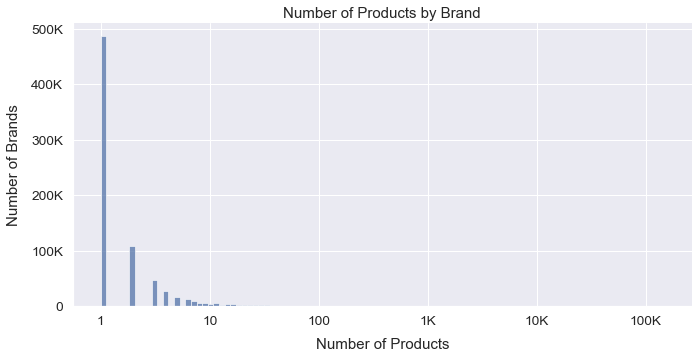

<IPython.core.display.Javascript object>

In [12]:
plot_brand_counts(df)

Over 500,000 brands have just one instance. I'm not interested in those.

In order to engineer a solid dataset for product classification, I'm going to keep only the biggest brands in each main category. That ought to get rid of most of the brand noise and make room for some signal.

For each main category, (with some exceptions) I keep only the top 1% of brands. Again, I'm measuring brand size in terms of number of products. Main categories with less than 1,000 samples are exempt from the pruning. Furthermore, all *none* entries will be dropped except in categories which are almost entirely *none* (in order to preserve the categories). The 'fine art' category, for instance, is ~99% *none*, presumably due to the unique nature of the products. Currently Amazon does show brands for fine art products, but that may have been different in 2018, when this data was collected.

In [13]:
# Drop brands below this quantile
qcut = 0.99

# Keep nulls if they dominate the category
null_dom_thresh = 0.95

# Don't prune small categories
protected_thresh = 1000

pruned_df = []

for cat, group in df.groupby("main_cat"):

    # Ignore small categories
    if len(group) <= protected_thresh:
        pruned_df.append(group)
        continue

    # Drop nulls if freq under `null_dom_thresh`
    brand_counts = group["brand"].value_counts(1)
    if brand_counts.get("none", 1.0) < null_dom_thresh:
        group = group.loc[group.brand != "none"]

    print(cat)
    print("-" * len(cat))

    # Drop brands below quantile `qcut`
    group = utils.prune_categories(group, "brand", qcut=qcut)

    print("\n")
    pruned_df.append(group)

pruned_df = pd.concat(pruned_df)

all beauty
----------
                       Status  Support
crystalage           retained       89
makingcosmetics      retained       80
kroo                 retained       67
crest                retained       64
vktech               retained       60
...                       ...      ...
huameidiy             dropped        1
non_toxic_solutions   dropped        1
extend_life           dropped        1
divine                dropped        1
facepro               dropped        1

[5175 rows x 2 columns]


all electronics
---------------
                Status  Support
sony          retained     1202
panasonic     retained     1137
samsung       retained      910
hp            retained      635
startech      retained      522
...                ...      ...
zelco          dropped        1
birdog_ultra   dropped        1
intelli_zone   dropped        1
bright_stone   dropped        1
vec            dropped        1

[12228 rows x 2 columns]


amazon fashion
--------------
         

[24660 rows x 2 columns]


handmade
--------
                         Status  Support
none                   retained     2212
unique                  dropped        6
marvel                  dropped        3
monster                 dropped        2
apple                   dropped        2
brenda_elaine_jewelry   dropped        1
lego                    dropped        1


health & personal care
----------------------
                          Status  Support
maxiaids                retained      139
liliane_memorials       retained      126
crystalage              retained      115
terravita               retained       89
big_dot_of_happiness    retained       88
...                          ...      ...
jaybrake                 dropped        1
anima_mundi_apothecary   dropped        1
healthywiser             dropped        1
kapaxen                  dropped        1
fifty_shades             dropped        1

[10323 rows x 2 columns]


home audio & theater
--------------------
     

[3187 rows x 2 columns]




<IPython.core.display.Javascript object>

In [14]:
size_reduct = 1 - (len(pruned_df) / len(df))
print(f"Reduced n_samples by {size_reduct:.0%}")
pruned_df

Reduced n_samples by 71%


text  \
asin                                                            
B000050AUH  philips sonicare standard brush head. sonic wa...   
B000050B62  norelco 5841xl deluxe reflex action cord/cordl...   
B000050B63  norelco 6826xl quadra action cord/cordless rec...   
B000050B64  norelco 6865xl quadra action cord/cordless rec...   
B000050B65  norelco 6885xl deluxe quadra action cord/cordl...   
...                                                       ...   
B01HH6JEOC  the sims 4 kids room stuff [online game code]....   
B01HIU43S4  1k games sega mega drive game console with wir...   
B01HIZF83S  bioshock: the collection - playstation 4. retu...   
B01HJ149LI  god eater resurrection - ps vita [digital code...   
B01HJ14FDA  jojo eyes of heaven complete bundle - ps4 [dig...   

                                                        title  \
asin                                                            
B000050AUH               philips sonicare standard brush head   
B000050B62  norelco 5841xl deluxe reflex action cord/cordl...   
B000050B63  norelco 6826xl quadra action cord/cordless rec...   
B000050B64  norelco 6865xl quadra action cord/cordless rec...   
B000050B65  norelco 6885xl deluxe quadra action cord/cordl...   
...                                                       ...   
B01HH6JEOC      the sims 4 kids room stuff [online game code]   
B01HIU43S4  1k games sega mega drive game console with wir...   
B01HIZF83S           bioshock: the collection - playstation 4   
B01HJ149LI    god eater resurrection - ps vita [digital code]   
B01HJ14FDA  jojo eyes of heaven complete bundle - ps4 [dig...   

                       brand     main_cat  
asin                                       
B000050AUH  philips_sonicare   all beauty  
B000050B62           norelco   all beauty  
B000050B63           norelco   all beauty  
B000050B64           norelco   all beauty  
B000050B65           norelco   all beauty  
...                      ...          ...  
B01HH6JEOC   electronic_arts  video games  
B01HIU43S4              sega  video games  
B01HIZF83S                2k  video games  
B01HJ149LI            bandai  video games  
B01HJ14FDA            bandai  video games  

[1068382 rows x 4 columns]

<IPython.core.display.Javascript object>

In [15]:
pruned_df.brand.nunique()

9109

<IPython.core.display.Javascript object>

This is an enormous dataset, so the top 1% of brands in each category leaves me with ~9k brands. That's a fairly large, yet manageable, number.

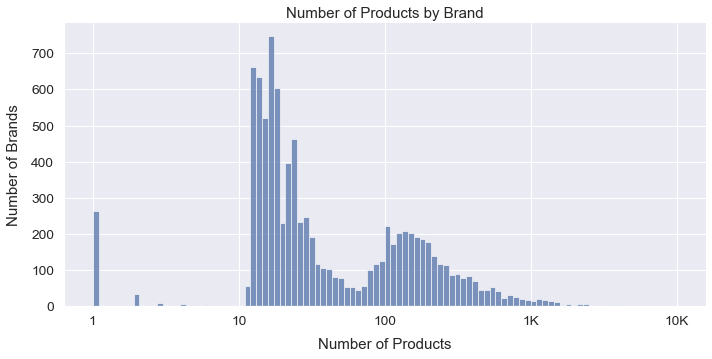

<IPython.core.display.Javascript object>

In [16]:
plot_brand_counts(pruned_df)

Although I only took the top 1% of brands in each category, most of the brands have 10-50 products. That seems like a healthy number.

The histogram also shows that there are ~400 single-product brands from the protected categories. That's fine. Those terms won't be very useful, but there's plenty of other useful information in those categories.

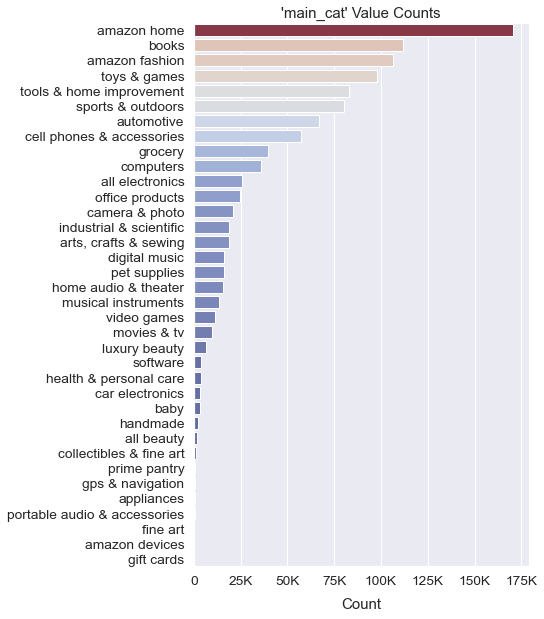

<IPython.core.display.Javascript object>

In [17]:
ax = plotting.plots.countplot(pruned_df.loc[:, "main_cat"], size=(6, 10))
ax.xaxis.set_major_formatter(plotting.big_number_formatter())

In [18]:
df = pruned_df
df.head()

text  \
asin                                                            
B000050AUH  philips sonicare standard brush head. sonic wa...   
B000050B62  norelco 5841xl deluxe reflex action cord/cordl...   
B000050B63  norelco 6826xl quadra action cord/cordless rec...   
B000050B64  norelco 6865xl quadra action cord/cordless rec...   
B000050B65  norelco 6885xl deluxe quadra action cord/cordl...   

                                                        title  \
asin                                                            
B000050AUH               philips sonicare standard brush head   
B000050B62  norelco 5841xl deluxe reflex action cord/cordl...   
B000050B63  norelco 6826xl quadra action cord/cordless rec...   
B000050B64  norelco 6865xl quadra action cord/cordless rec...   
B000050B65  norelco 6885xl deluxe quadra action cord/cordl...   

                       brand    main_cat  
asin                                      
B000050AUH  philips_sonicare  all beauty  
B000050B62           norelco  all beauty  
B000050B63           norelco  all beauty  
B000050B64           norelco  all beauty  
B000050B65           norelco  all beauty

<IPython.core.display.Javascript object>

I check the brands of 'arts, crafts, & sewing' as a basic sanity check.

In [19]:
df.groupby("main_cat").get_group("arts, crafts & sewing").brand.value_counts()

lantern_press               1030
3drose                       829
beadaholique                 795
sizzix                       696
spellbinders                 597
                            ... 
moda                          86
crafter_companion             85
unique_wood_shapes            85
vogue_fabrics                 83
sparkles_make_it_special      82
Name: brand, Length: 96, dtype: int64

<IPython.core.display.Javascript object>

Seems to be a healthy number.

## Engineering the Vocabulary

I engineer the model's vocabulary by preprocessing the text, developing a custom tokenizer, and constructing multi-word expressions. The purpose of the model is to assimilate novel products into Amazon's existing classification scheme. If the vocabulary is to serve that purpose, it will require some *a priori* decision-making.

To be clear, I don't intend to feed `TfidfVectorizer` a fixed vocabulary, because that would restrict my ability to tune the vocabulary later on. I plan on letting the vectorizer learn the vocabulary on its own, but I want it to learn the *right* vocabulary.

Before making any decisions, I define a function for creating a vocabulary from a sample of the corpus.

In [20]:
def build_sample_vocab(
    corpus,
    n_docs,
    *,
    tokenizer=None,
    sortby="length",
    random_state=363,
    n_jobs=-1,
):
    # Get sample of corpus
    if n_docs is None:
        samp_corpus = corpus
    else:
        samp_corpus = corpus.sample(n_docs, random_state=random_state)

    # Tokenize
    if tokenizer is None:
        # Check if already tokenized
        if not pd.api.types.is_list_like(corpus.iloc[0]):
            samp_corpus = lang.space_tokenize(samp_corpus, n_jobs=n_jobs)
    else:
        samp_corpus = lang.process_strings(samp_corpus, tokenizer, n_jobs=n_jobs)

    # Build vocabulary
    vocab = samp_corpus.explode().value_counts()
    vocab = vocab.reset_index(name="freq").rename(columns={"index": "term"})

    # Add additional stats
    vocab["length"] = vocab.loc[:, "term"].str.len()
    vocab["uniq_ratio"] = vocab.loc[:, "term"].map(lang.uniq_ratio)

    return vocab.sort_values(sortby, ascending=False)

<IPython.core.display.Javascript object>

### Optimize the Tokenizer?

There are many tokenizers on the market. Shouldn't I grid-search over them all to maximize my accuracy score?

No. The choice of tokenizer requires some *human* intelligence. The purpose of the model is to classify new products into Amazon's existing categories. High test scores do not always indicate a better model&mdash;sometimes, they reflect overfitting.

Take for example `nltk.wordpunct_tokenize`. This tokenizer captures arbitrarily long sequences of punctuation in addition to normal words.

In [30]:
# Get small sample of corpus
wordpunct_vocab = build_sample_vocab(
    df.loc[:, "text"], 10 ** 4, tokenizer=nltk.wordpunct_tokenize
)

# Slice out some punctuation
wordpunct_vocab.loc[wordpunct_vocab.term.str.startswith("!"), "term"].head(10)

23965    !~~~~~~~~~~~~~~~~~
46177           !!!!!!!!!!.
50563             !!!~~~~~~
64273               !!!!!!.
45913                 !!!!.
46304                 !!!!!
62247                  !").
14265                  !!!.
22183                  !!!!
48569                  !"".
Name: term, dtype: object

<IPython.core.display.Javascript object>

In [31]:
del wordpunct_vocab

<IPython.core.display.Javascript object>

 The problem is that these sequences are *artifacts* of this particular dataset. Suppose that the model learns to associate '#############' with the 'automotive' category and '&&&&&&&&!?!?!?' with 'baby'. That might be a real pattern in this particular dataset, but it's useless in general.

I begin with the the Scikit-Learn default tokenizer that I used on the brands. It captures sequences of two or more alphanumeric characters within a word boundary. It ignores punctuation and single letters, which results in very clean tokens. For example, 'Frank's' becomes 'Frank'. It's also lightning fast because it's just a regular expression.

In [32]:
# Get small sample of corpus
sklearn_vocab = build_sample_vocab(
    df.loc[:, "text"], 10 ** 4, tokenizer=sklearn_tokenize
)
sklearn_vocab.sort_values("length", ascending=False, inplace=True)

# Slice out numeric strings, sort by length
sklearn_vocab.loc[sklearn_vocab.term.str.isnumeric(), "term"].head(10)

40321    0020473440003353
40731      10763649016517
43137      10763649016562
54494      10763649016548
56645      10763649016531
56302       7636490015113
67215       7636490015090
58471       9781612430232
64538       9781569759301
49147       4051771017106
Name: term, dtype: object

<IPython.core.display.Javascript object>

In [33]:
del sklearn_vocab

<IPython.core.display.Javascript object>

One problem with the Scikit-Learn tokenizer is that it produces code-like numeric sequences. My goal is not to create a model which picks up on ultra-rare ID numbers and codes for specific products, but to create a model which recognizes broad patterns in **natural language**.

I define my own tokenizer in the cell below.

In [34]:
def my_tokenize_1(docs, n_jobs=None):
    pattern = re.compile(r"(?i)\b[a-z_]{2,}\b")
    return lang.process_strings(docs, pattern.findall, n_jobs=n_jobs)

<IPython.core.display.Javascript object>

The tokenizer I created above captures sequences of two or more alphabetic ASCII characters (plus underscore) `'[a-z_]{2,}'` within word boundaries `'\b'` while ignoring case `(?i)`. It ignores non-ASCII characters including accented letters, which I deliberately conflate with their non-accented counterparts.

In [35]:
df["text"] = lang.force_ascii(df.loc[:, "text"], n_jobs=-1)
df["text"].head()

asin
B000050AUH    philips sonicare standard brush head. sonic wa...
B000050B62    norelco 5841xl deluxe reflex action cord/cordl...
B000050B63    norelco 6826xl quadra action cord/cordless rec...
B000050B64    norelco 6865xl quadra action cord/cordless rec...
B000050B65    norelco 6885xl deluxe quadra action cord/cordl...
Name: text, dtype: object

<IPython.core.display.Javascript object>

One thing my tokenizer doesn't address is tokens that are too long.

In [36]:
samp_vocab = build_sample_vocab(df.loc[:, "text"], 10 ** 4, tokenizer=my_tokenize_1)

samp_vocab.head(10)

term  freq  length  uniq_ratio
33784  lovepoemsandmorefromtheheartandsoulofman     1      40    0.375000
48543          enclosurefeaturesalightweightyet     1      32    0.500000
34725             atramentizedpolishedinsulated     1      29    0.517241
32056             the_strictly_mint_card_co_inc     2      29    0.517241
33143              green_compliance_certificate     2      28    0.500000
33345              mmpliersheadhandlesstripping     1      28    0.464286
45765               atramentizedpolishedplastic     1      27    0.555556
33552                instructionsmarkingoptions     1      26    0.500000
44334                ninjagocoleminifigurebuilt     1      26    0.576923
26275                 autotruckmirrorsunlimited     2      25    0.560000

<IPython.core.display.Javascript object>

As you can see, most of these 20+ character strings are just idiosyncratic noise. Take for example the term 'sherryguzzlinggranny':

In [37]:
granny_book = df.loc[df.text.str.contains("sherryguzzlinggranny")].iloc[0]
display(granny_book)
granny_book.text

text        queen of babble gets hitched. when last seen, ...
title                            queen of babble gets hitched
brand                                               meg_cabot
main_cat                                                books
Name: 006085202X, dtype: object

"queen of babble gets hitched. when last seen, the irrepressible lizzie nichols was canoodling with chaz after she and luke, chaz's best friend, broke up ( queen of babble in the big city , 2007). nowshocker alertluke returns to new york and slips a three-carat diamond engagement ring on her finger. lizzie accepts even though she's still all googly over chaz, who bluntly warns lizzie that luke's all about luke and couldn't love her the way he does. lizzie, a wedding dress restorer and budding designer specializing in wedding garb, faces a hives-inducing decision: dump rich luke, who wants to be an investment banker in paris, and hook up with chaz, who wants to teach? or should she marry luke and ditch new york for paris? and then there's the matter of her burgeoning design business, helped along by ava geck, a paris hiltonlike celebrity heiress. cabot takes full advantage of the material, delivering her trademark wit, sharp banter and lively antics from the first page. fans of the seri

<IPython.core.display.Javascript object>

The term 'sherryguzzlinggranny' comes from the book *Queen of Babble Gets Hitched*. The description (above) contains a number of similar typos, such as 'lizziesbad-mouthed', 'high-strungassistant', and 'amusingreaders'. I have no qualms about filtering these out.

Next I get a larger sample and examine the length distribution.

In [38]:
samp_vocab = build_sample_vocab(df.loc[:, "text"], 10 ** 5, tokenizer=my_tokenize_1)

samp_vocab.sample(10)

term  freq  length  uniq_ratio
103252  tetrafluoroethane     1      17    0.588235
139513             tibets     1       6    0.833333
20297                trax    39       4    1.000000
89198               nacin     2       5    0.800000
81155               burmy     2       5    1.000000
2268               marvel  1186       6    1.000000
89433            swanston     2       8    0.750000
66075            tricking     3       8    0.875000
144123      electrocution     1      13    0.692308
144338                mlk     1       3    1.000000

<IPython.core.display.Javascript object>

Next I examine the length distribution to determine a good cutoff point for length outliers. The plot is annotated with the IQR and Tukey's fences (i.e. boxplot whiskers).

<AxesSubplot:xlabel='length', ylabel='Count'>

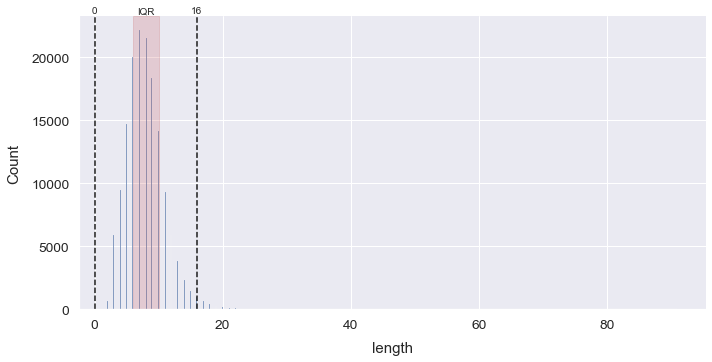

<IPython.core.display.Javascript object>

In [39]:
g = sns.displot(data=samp_vocab, x="length", kind="hist", aspect=2)
plotting.add_tukey_marks(samp_vocab["length"], g.axes[0, 0], num_format=".0f")

           n_trimmed  pct_trimmed
length         2,025            1
total_obs      2,025            1


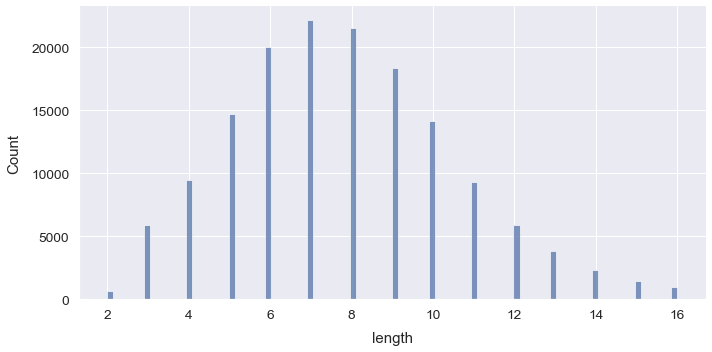

<IPython.core.display.Javascript object>

In [40]:
inlier_idx = outliers.tukey_trim(samp_vocab["length"]).index
samp_vocab = samp_vocab.loc[inlier_idx]
sns.displot(data=samp_vocab, x="length", kind="hist", aspect=2)

16 seems like a natural cutoff for word length, and it's what Tukey's IQR proximity rule dictates. I rewrite my token pattern to match sequences between two and 16 characters (inclusive).

In [41]:
def my_tokenize_2(docs, n_jobs=None):
    pattern = re.compile(r"(?i)\b[a-z_]{2,16}\b")
    return lang.process_strings(docs, pattern.findall, n_jobs=n_jobs)

<IPython.core.display.Javascript object>

In [42]:
del my_tokenize_1

<IPython.core.display.Javascript object>

In [43]:
samp_vocab.loc[samp_vocab.term.str.count("_") > 2]

term  freq  length  uniq_ratio
134020  sheet_size_w_x_h     1      16    0.562500
147774   ____description     1      15    0.733333
141079         ____notes     1       9    0.666667
75847             ______     2       6    0.166667
40388              _____     9       5    0.200000
88547               ____     2       4    0.250000
54523                ___     5       3    0.333333

<IPython.core.display.Javascript object>

I'm not interested in any of the underscores already in the data, only ones that I might add.

In [44]:
df["text"] = lang.strip_punct(df.loc[:, "text"], n_jobs=-1)
df["text"].str.contains("_").any()

False

<IPython.core.display.Javascript object>

A related source of noise are strings with repetitive character (or word) sequences.

In [45]:
samp_vocab = build_sample_vocab(df.loc[:, "text"], 10 ** 5, tokenizer=my_tokenize_2)
samp_vocab.sort_values("uniq_ratio").head(10)

term  freq  length  uniq_ratio
105942    xxxxxxxxxxxx     1      12    0.083333
126513         xxxxxxx     1       7    0.142857
108018         zzzzzzz     1       7    0.142857
96349   wooooooooooooo     1      14    0.142857
95987    gaaaaaaaaaaaa     1      13    0.153846
74755           cccccc     2       6    0.166667
112457          ffffff     1       6    0.166667
91582           xxxxxx     2       6    0.166667
91424            aaaaa     2       5    0.200000
60478            xxxxx     4       5    0.200000

<IPython.core.display.Javascript object>

The above terms with repetitive sequences have low character uniqueness ratios, i.e. the ratio of character types to character tokens. That's how I'll filter them out.

Note: long multi-word amalgamations also have low character uniqueness simply because of their length, but I've already weeded those out.

<AxesSubplot:xlabel='uniq_ratio', ylabel='Count'>

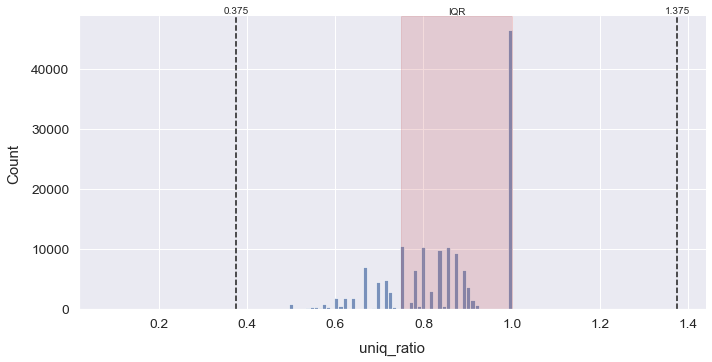

<IPython.core.display.Javascript object>

In [46]:
g = sns.displot(data=samp_vocab, x="uniq_ratio", kind="hist", aspect=2)
plotting.add_tukey_marks(samp_vocab["uniq_ratio"], g.axes[0, 0], num_format=".3f")

The lower Tukey fence is located at 0.375. That seems like a reasonable cutoff.

In [47]:
# Tokenize the text
df["text"] = my_tokenize_2(df.loc[:, "text"], n_jobs=-1)
df["text"].head()

asin
B000050AUH    [philips, sonicare, standard, brush, head, son...
B000050B62    [norelco, deluxe, reflex, action, cord, cordle...
B000050B63    [norelco, quadra, action, cord, cordless, rech...
B000050B64    [norelco, quadra, action, cord, cordless, rech...
B000050B65    [norelco, deluxe, quadra, action, cord, cordle...
Name: text, dtype: object

<IPython.core.display.Javascript object>

In [48]:
# functools.partial holds argument in place
uniq_char_thresh = partial(lang.uniq_char_thresh, thresh=0.375)

# Remove low uniqueness ratios
df["text"] = df.loc[:, "text"].map(uniq_char_thresh)
df["text"].head()

asin
B000050AUH    [philips, sonicare, standard, brush, head, son...
B000050B62    [norelco, deluxe, reflex, action, cord, cordle...
B000050B63    [norelco, quadra, action, cord, cordless, rech...
B000050B64    [norelco, quadra, action, cord, cordless, rech...
B000050B65    [norelco, deluxe, quadra, action, cord, cordle...
Name: text, dtype: object

<IPython.core.display.Javascript object>

In [49]:
samp_vocab.loc[samp_vocab.uniq_ratio > 0.375].sort_values("uniq_ratio").head(10)

term  freq  length  uniq_ratio
76889   reengineering     2      13    0.384615
142152  sleeplessness     1      13    0.384615
53508   totallytattoo     5      13    0.384615
5330       sleeveless   387      10    0.400000
127105     reassesses     1      10    0.400000
58844           mamma     4       5    0.400000
46913      hfuhruhurr     6      10    0.400000
70724      tennesseee     3      10    0.400000
34831           eevee    12       5    0.400000
109057          afafa     1       5    0.400000

<IPython.core.display.Javascript object>

Looks better. If I raise the threshold more, I'll begin to filter out too many normal words.

## Restricting to English

Next I run [langdetect](https://pypi.org/project/langdetect/) (a Google language detection algorithm) on the documents and select only the English product descriptions. I have nothing against the other languages, but there are not enough examples of them in the dataset to build a truly multilingual model. I don't want the model to associate Spanish words with 'amazon fashion', for example. That would generalize poorly.

This cell takes 30-40 minutes to run if `RUN_LANGDETECT` is set.

In [50]:
if RUN_LANGDETECT:
    # Wrapper of `langdetect.detect` with multiprocessing
    df["lang"] = lang.detect_lang(df.loc[:, "text"], seed=0, n_jobs=-1)
    df["lang"].to_json("data/langdetect.json")
else:
    df["lang"] = pd.read_json("data/langdetect.json", typ="series")

    # Run on missing
    missing = df["lang"].isna()
    if missing.any():
        df.loc[missing, "lang"] = lang.detect_lang(
            df.loc[missing, "text"].str.join(" "),
            seed=51,
            n_jobs=-1,
        )
        # Save new results
        df["lang"].to_json("data/langdetect.json")

df["lang"].value_counts()

en    1066097
es        988
fr        200
it        200
pt        133
no        117
nl        116
de        112
da         84
id         56
ca         49
sv         39
af         29
ro         25
pl         22
so         19
sl         12
tl         12
cs         10
sw         10
hr         10
lt          9
cy          7
et          7
hu          5
tr          5
fi          3
sq          2
sk          2
lv          1
vi          1
Name: lang, dtype: int64

<IPython.core.display.Javascript object>

In [51]:
df = df.loc[df.lang == "en"]
df["lang"].value_counts()

en    1066097
Name: lang, dtype: int64

<IPython.core.display.Javascript object>

In [52]:
len(df)

1066097

<IPython.core.display.Javascript object>

## Removing Stopwords

Before searching for collocations, I want to remove stopwords. As you can see below, there are quite a few in the vocabulary.

In [53]:
samp_vocab = build_sample_vocab(df.loc[:, "text"], 10 ** 4, sortby="freq")
samp_vocab.head(10)

term   freq  length  uniq_ratio
0   the  71611       3         1.0
1   and  65843       3         1.0
2    to  38229       2         1.0
3    of  35550       2         1.0
4   for  28322       3         1.0
5  with  26181       4         1.0
6    in  25225       2         1.0
7    is  21039       2         1.0
8  your  14172       4         1.0
9  this  12594       4         1.0

<IPython.core.display.Javascript object>

In [54]:
# Fetch stopwords
stop = lang.fetch_stopwords("nltk_english")
# Run through tokenizer
stop = {y for x in stop for y in my_tokenize_2(x)}
# Make sure there are no brand terms
stop = stop.difference(df["brand"])
pprint(stop, compact=True)

{'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and',
 'any', 'are', 'aren', 'as', 'be', 'because', 'been', 'before', 'being',
 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', 'did', 'didn', 'do',
 'does', 'doesn', 'doing', 'don', 'down', 'during', 'each', 'few', 'for',
 'from', 'further', 'had', 'hadn', 'has', 'hasn', 'have', 'haven', 'having',
 'he', 'her', 'here', 'hers', 'herself', 'him', 'himself', 'his', 'how', 'if',
 'in', 'into', 'is', 'isn', 'it', 'its', 'itself', 'just', 'll', 'ma', 'me',
 'mightn', 'more', 'most', 'mustn', 'my', 'myself', 'needn', 'no', 'nor', 'not',
 'now', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours',
 'ourselves', 'out', 'over', 'own', 're', 'same', 'shan', 'she', 'should',
 'shouldn', 'so', 'some', 'such', 'than', 'that', 'the', 'their', 'theirs',
 'them', 'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
 'through', 'to', 'too', 'under', 'until', 'up', 've', 'very', 'was', 'wasn',
 '

<IPython.core.display.Javascript object>

I add some more domain-specific stopwords.

In [55]:
more_stop = [
    "none",
    "inches",
    "shipping",
    "shipped",
    "shipper",
    "shipments",
    "weight",
    "pounds",
    "ounces",
    "asin",
    "item",
    "item_number",
    "model_number",
    "listed",
    "within",
    "apo",
    "fpo",
    "address",
    "addresses",
    "support",
    "eligible",
    "customer",
    "review",
    "reviews",
    "reviewer",
    "reviewed",
]
stop.update({y for x in more_stop for y in my_tokenize_2(x)})
pprint(stop, compact=True)

{'about', 'above', 'address', 'addresses', 'after', 'again', 'against', 'ain',
 'all', 'am', 'an', 'and', 'any', 'apo', 'are', 'aren', 'as', 'asin', 'be',
 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by',
 'can', 'couldn', 'customer', 'did', 'didn', 'do', 'does', 'doesn', 'doing',
 'don', 'down', 'during', 'each', 'eligible', 'few', 'for', 'fpo', 'from',
 'further', 'had', 'hadn', 'has', 'hasn', 'have', 'haven', 'having', 'he',
 'her', 'here', 'hers', 'herself', 'him', 'himself', 'his', 'how', 'if', 'in',
 'inches', 'into', 'is', 'isn', 'it', 'item', 'item_number', 'its', 'itself',
 'just', 'listed', 'll', 'ma', 'me', 'mightn', 'model_number', 'more', 'most',
 'mustn', 'my', 'myself', 'needn', 'no', 'none', 'nor', 'not', 'now', 'of',
 'off', 'on', 'once', 'only', 'or', 'other', 'ounces', 'our', 'ours',
 'ourselves', 'out', 'over', 'own', 'pounds', 're', 'review', 'reviewed',
 'reviewer', 'reviews', 'same', 'shan', 'she', 'shipments', 'shipped',
 'shipper',

<IPython.core.display.Javascript object>

In [56]:
samp_vocab = build_sample_vocab(df["text"], 10 ** 4, sortby="freq")
samp_vocab.head(10)

term   freq  length  uniq_ratio
0   the  71611       3         1.0
1   and  65843       3         1.0
2    to  38229       2         1.0
3    of  35550       2         1.0
4   for  28322       3         1.0
5  with  26181       4         1.0
6    in  25225       2         1.0
7    is  21039       2         1.0
8  your  14172       4         1.0
9  this  12594       4         1.0

<IPython.core.display.Javascript object>

In [57]:
# functools.partial wraps the func and holds `stop` in place
remove_my_stop = partial(lang.remove_stopwords, stopwords=stop)

df = df.assign(text=df.loc[:, "text"].map(remove_my_stop))
df["text"].head()

asin
B000050AUH    [philips, sonicare, standard, brush, head, son...
B000050B62    [norelco, deluxe, reflex, action, cord, cordle...
B000050B63    [norelco, quadra, action, cord, cordless, rech...
B000050B64    [norelco, quadra, action, cord, cordless, rech...
B000050B65    [norelco, deluxe, quadra, action, cord, cordle...
Name: text, dtype: object

<IPython.core.display.Javascript object>

## Multi-word Expressions

I already have a lot of high quality brand phrases which I expect to be strong features for the model. I'll go ahead and prepare those.

In [58]:
brand_ng = df.loc[:, "brand"].drop_duplicates().str.split("_").map(tuple)
brand_ng = brand_ng.loc[brand_ng.map(len) > 1]
brand_ng

asin
B000050AUH               (philips, sonicare)
B000050B6B                (philips, norelco)
B0000531WK                    (oreal, paris)
B0000532QF                  (tom, of, maine)
B000066SYD                     (aqua, fresh)
                           ...              
B00008YGO2                    (mumbo, jumbo)
B000ASBKGA                    (cta, digital)
B0017IK8W4                    (deep, silver)
B001K7HUUK           (alawar, entertainment)
B00GQVGV9Q    (big, leap, studios, pvt, ltd)
Name: brand, Length: 6777, dtype: object

<IPython.core.display.Javascript object>

I search for collocations in the text in a stratified fashion, scanning the documents of each 'main_cat' category as a separate corpus. The goal is to find ngrams which are peculiar to each category. I use pointwise mutual information (PMI) to identify bigrams.

In [59]:
cat_bg = lang.stratified_ngrams(
    # Join tokens back together
    df.assign(text=df.loc[:, "text"].str.join(" ")),
    n=2,
    text="text",
    # Stratify by 'main_cat'
    cat="main_cat",
    tokenizer=my_tokenize_2,
    # Use pointwise mutual information
    metric="pmi",
    # Select top 75% of scores in each category
    select_best=0.75,
    # Filter out ultra-rare ngrams
    min_freq=100,
    n_jobs=-1,
)
cat_bg

bigram     score     main_cat
0             (year, warranty)  9.750503   all beauty
1                 (tom, maine)  9.687209   all beauty
2                 (old, spice)  9.514352   all beauty
3                (diamond, fx)  9.006641   all beauty
4                (pro, health)  8.985854   all beauty
...                        ...       ...          ...
114142           (two, player)  4.935113  video games
114143  (additional, features)  4.924453  video games
114144        (gives, players)  4.897825  video games
114145         (xbox, account)  4.892873  video games
114146     (ultimate, edition)  4.882772  video games

[114147 rows x 3 columns]

<IPython.core.display.Javascript object>

In [60]:
# Merge ngrams into single list
phrases = cat_bg.bigram.append(brand_ng).drop_duplicates().to_list()
display(len(phrases))
phrases[:10]

98443

[('year', 'warranty'),
 ('tom', 'maine'),
 ('old', 'spice'),
 ('diamond', 'fx'),
 ('pro', 'health'),
 ('face', 'paint'),
 ('philips', 'sonicare'),
 ('philips', 'norelco'),
 ('brand', 'new'),
 ('high', 'quality')]

<IPython.core.display.Javascript object>

In [61]:
ngram_tokenize = nltk.MWETokenizer(phrases).tokenize
ngram_tokenize

<bound method MWETokenizer.tokenize of <nltk.tokenize.mwe.MWETokenizer object at 0x00000258FE396E20>>

<IPython.core.display.Javascript object>

In [63]:
df["text"] = df.loc[:, "text"].map(ngram_tokenize)

df["text"].head()

asin
B000050AUH    [philips_sonicare, standard, brush_head, sonic...
B000050B62    [norelco, deluxe, reflex, action, cord, cordle...
B000050B63    [norelco, quadra, action, cord, cordless, rech...
B000050B64    [norelco, quadra, action, cord, cordless, rech...
B000050B65    [norelco, deluxe, quadra, action, cord, cordle...
Name: text, dtype: object

<IPython.core.display.Javascript object>

Next, I add stopwords which I've seen in a vision of the future.

In [64]:
df["text"] = df.loc[:, "text"].str.join(" ")
df["text"].head()

asin
B000050AUH    philips_sonicare standard brush_head sonic wav...
B000050B62    norelco deluxe reflex action cord cordless rec...
B000050B63    norelco quadra action cord cordless rechargeab...
B000050B64    norelco quadra action cord cordless rechargeab...
B000050B65    norelco deluxe quadra action cord cordless rec...
Name: text, dtype: object

<IPython.core.display.Javascript object>

In [65]:
if os.path.exists("data/model_data"):
    shutil.rmtree("data/model_data")

df.to_parquet(
    "data/model_data",
    engine="pyarrow",
    index=True,
    partition_cols="main_cat",
)

<IPython.core.display.Javascript object>


# Modeling
## Performing the Split

In [10]:
df = pd.read_parquet("data/model_data", engine="pyarrow")
df.head()

text  \
asin                                                            
B000050AUH  philips_sonicare standard brush_head sonic wav...   
B000050B62  norelco deluxe reflex action cord cordless rec...   
B000050B63  norelco quadra action cord cordless rechargeab...   
B000050B64  norelco quadra action cord cordless rechargeab...   
B000050B65  norelco deluxe quadra action cord cordless rec...   

                                                        title  \
asin                                                            
B000050AUH               philips sonicare standard brush head   
B000050B62  norelco 5841xl deluxe reflex action cord/cordl...   
B000050B63  norelco 6826xl quadra action cord/cordless rec...   
B000050B64  norelco 6865xl quadra action cord/cordless rec...   
B000050B65  norelco 6885xl deluxe quadra action cord/cordl...   

                       brand lang    main_cat  
asin                                           
B000050AUH  philips_sonicare   en  all beauty  
B000050B62           norelco   en  all beauty  
B000050B63           norelco   en  all beauty  
B000050B64           norelco   en  all beauty  
B000050B65           norelco   en  all beauty

<IPython.core.display.Javascript object>

In [11]:
X = df.loc[:, "text"]
y = df.loc[:, "main_cat"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=49, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((799572,), (266525,), (799572,), (266525,))

<IPython.core.display.Javascript object>

Next, I create the vectorizer. I have a taste for interpretability and transparency, which is why I've opted to use term-frequency vectorization (e.g. binary occurrence, raw term-frequency, or TF\*IDF). For the baseline model, I turn off IDF weighting and normalization. Therefore, `tf` is initially set to extract raw term-frequency vectors from the text.

In [12]:
tf = TfidfVectorizer(
    lowercase=False,
    token_pattern=r"(?i)\b[a-z_]{2,16}\b",
    norm=None,
    use_idf=False,
)

tf

TfidfVectorizer(lowercase=False, norm=None,
                token_pattern='(?i)\\b[a-z_]{2,16}\\b', use_idf=False)

<IPython.core.display.Javascript object>

I've opted to use Scikit-Learn's `SGDClassifier` because it's efficient on large datasets and works with several different loss functions. Essentially, it offers widely used linear classifiers with stochastic gradient descent optimization.

I could have also chosen a neural network classifier such as Scikit-Learn's ready-made multi-layer perceptron. However, neural networks take a long time to train and are the least interpretable algorithms on the market. For this project, given my limited computational resources and personal tastes, I've opted for a more traditional approach.

In [13]:
sgd = SGDClassifier(
    loss="hinge",
    class_weight="balanced",
    n_jobs=-1,
)

sgd

SGDClassifier(class_weight='balanced', n_jobs=-1)

<IPython.core.display.Javascript object>

The default loss function 'hinge' is a linear support vector classifier. `SGDClassifier` also offers squared hinge, logistic regression, modified Huber, and several losses designed for regression.

Next, I create a pipeline containing just two steps: the vectorizer and the classifier.

In [14]:
pipe = Pipeline(
    [
        ("vec", tf),
        ("cls", sgd),
    ],
    verbose=True,
)
pipe

Pipeline(steps=[('vec',
                 TfidfVectorizer(lowercase=False, norm=None,
                                 token_pattern='(?i)\\b[a-z_]{2,16}\\b',
                                 use_idf=False)),
                ('cls', SGDClassifier(class_weight='balanced', n_jobs=-1))],
         verbose=True)

<IPython.core.display.Javascript object>

The [User Guide](https://scikit-learn.org/stable/modules/sgd.html#sgd) emphasizes that `SGDClassifier` is sensitive to feature scale. However, since word frequencies are already on the same scale, there is no need to include a scaler.

A related concern is vector normalization (sample scale). The User Guide states that the default learning rate formula (`learning_rate='optimal'`) assumes "that the norm of the training samples is approx. 1." Another reason to normalize the vectors is to minimize the effect of document length. Again, I've turned it off for the baseline, but I fully expect to turn it back on later.

Next I define some functions which I'll use throughout the modeling process.

In [15]:
def plot_confusion_matrix(
    estimator,
    X_test=X_test,
    y_test=y_test,
    dst=None,
    xticks_rotation="vertical",
    **kwargs,
):
    """Plots confusion matrix with accuracy score."""
    ax = plotting.confusion_matrix(
        estimator,
        X_test,
        y_test,
        xticks_rotation=xticks_rotation,
        **kwargs,
    )
    y_pred = estimator.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    ax.set_title(f"Accuracy: {acc:.2f}, Balanced Accuracy: {bal_acc:.2f}", pad=5)
    if isinstance(dst, str):
        plt.savefig(dst)
    return ax

<IPython.core.display.Javascript object>

In [16]:
def get_report(estimator, X_test=X_test, y_test=y_test):
    """Returns standard classification metrics as a DataFrame."""
    report = classification_report(y_test, estimator.predict(X_test), output_dict=True)
    report = pd.DataFrame(report).T
    report.loc["accuracy", "support"] = report["support"].max()
    return report

<IPython.core.display.Javascript object>

In [17]:
def extract_coef(
    pipeline,
    classifier="cls",
    vectorizer="vec",
):
    """Returns labeled model coefficients as a DataFrame."""
    columns = np.array(pipeline[vectorizer].get_feature_names())
    coef = pd.DataFrame(
        pipeline[classifier].coef_,
        index=pipeline[classifier].classes_,
        columns=columns,
    ).T
    return coef

<IPython.core.display.Javascript object>

## Fitting the Baseline

Without further ado, it's time to fit the baseline model.

In [75]:
if "svm_1" in FIT_MODELS:
    # Train the model (slow)
    pipe.fit(X_train, y_train)
    joblib.dump(pipe, "models/svm_1.joblib", compress=True)

else:
    # Load the saved model (fast)
    pipe = joblib.load("models/svm_1.joblib")
pipe

[Pipeline] ............... (step 1 of 2) Processing vec, total= 1.1min
[Pipeline] ............... (step 2 of 2) Processing cls, total=  42.0s


Pipeline(steps=[('vec',
                 TfidfVectorizer(lowercase=False, norm=None,
                                 token_pattern='(?i)\\b[a-z_]{2,16}\\b',
                                 use_idf=False)),
                ('cls', SGDClassifier(class_weight='balanced', n_jobs=-1))],
         verbose=True)

<IPython.core.display.Javascript object>

Since these models take a couple minutes to train, I always save them so they can be quickly reloaded.

In [76]:
len(pipe["vec"].get_feature_names())

491581

<IPython.core.display.Javascript object>

490K features is a lot, but not bad considering the size of the dataset. I'm sure it would've been much larger if not for my extensive preprocessing efforts.

<AxesSubplot:title={'center':'Accuracy: 0.95, Balanced Accuracy: 0.91'}, xlabel='Predicted label', ylabel='True label'>

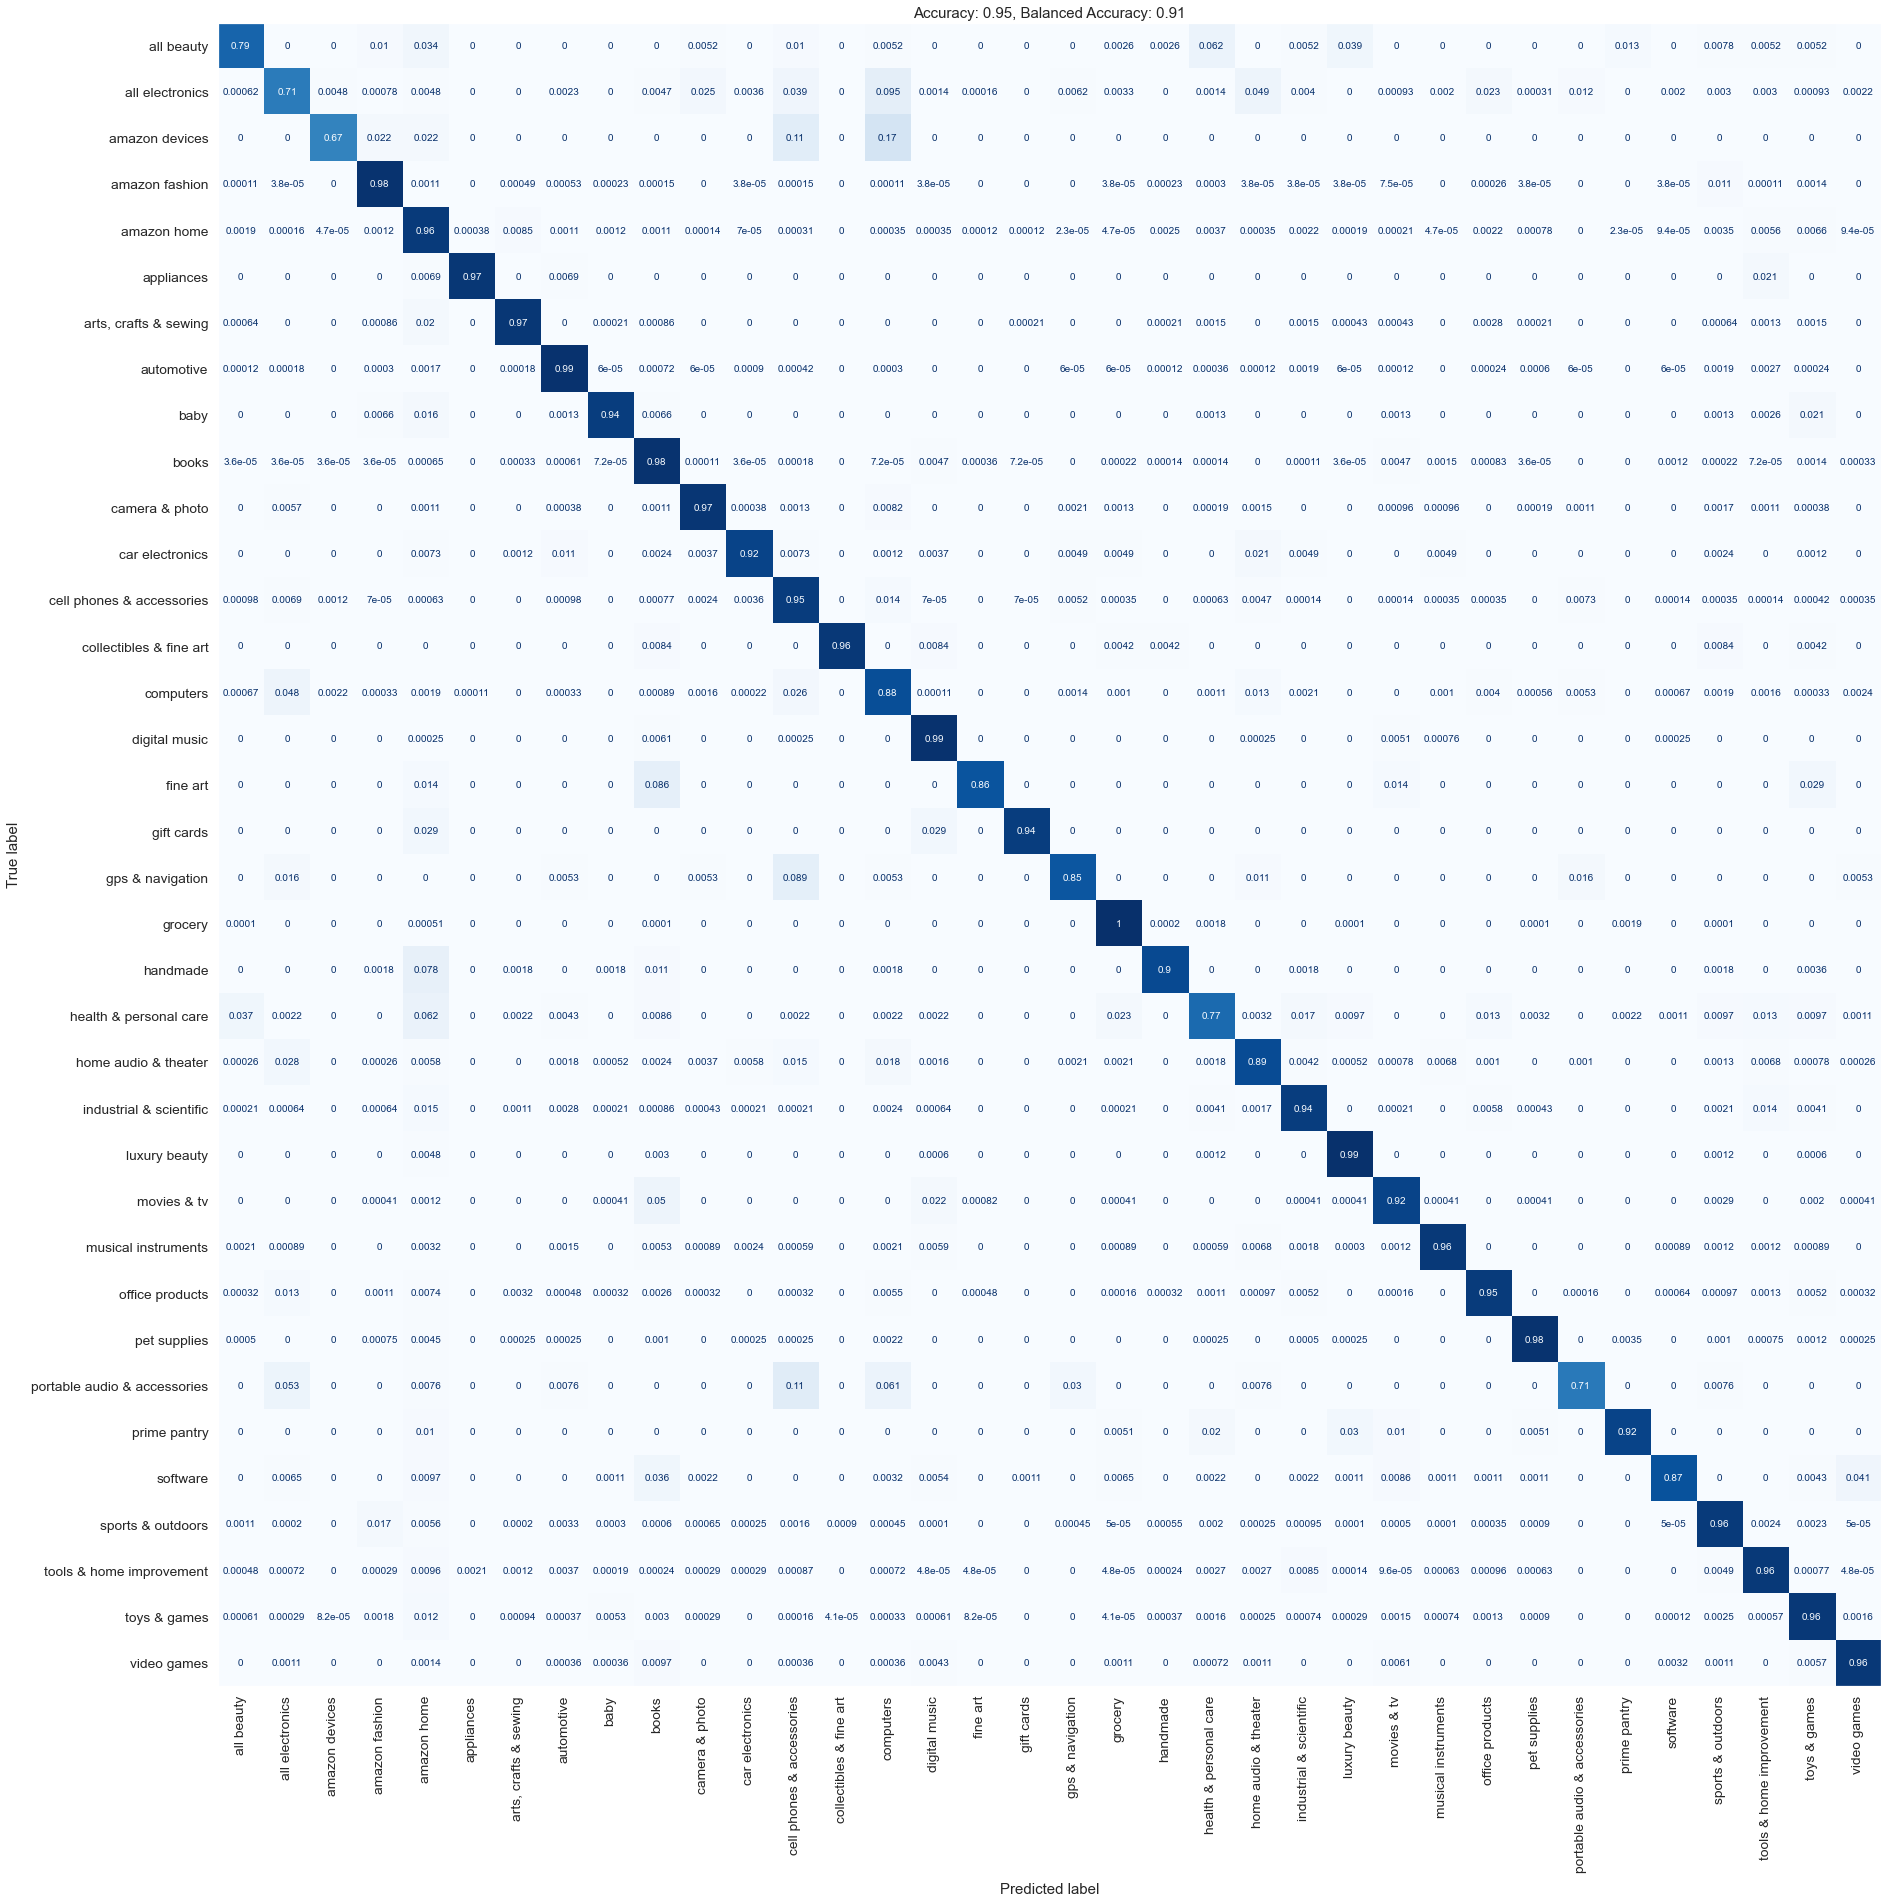

<IPython.core.display.Javascript object>

In [77]:
plot_confusion_matrix(pipe, dst="figures/svm_1_cm.svg")

Not bad for a baseline! Is it too good to be true, or have my painstaking efforts simply paid off? Let's look at the coefficients.

In [78]:
coef = extract_coef(pipe)
coef.sort_values("all electronics", ascending=False).head(10)

all beauty  all electronics  amazon devices  amazon fashion  \
riorand         -0.037515         1.799621        0.000000       -0.025009   
kenable          0.000000         1.136051        0.000000       -0.014068   
amscope          0.000000         1.104640       -0.011463        0.000000   
silverstone      0.000000         1.072703        0.000000        0.004354   
javoedge        -0.012505         1.000720        0.487363       -0.003126   
thermaltake     -0.002779         1.000517       -0.005211        0.000000   
ocz              0.000000         0.993562       -0.002084        0.000000   
altec_lansing    0.000000         0.982081       -0.014590        0.000000   
trendnet         0.000000         0.939626       -0.009379        0.000000   
pny              0.000000         0.924110       -0.002084        0.000000   

               amazon home  appliances  arts, crafts & sewing  automotive  \
riorand          -0.124012   -0.002779               0.000000   -0.046893   
kenable          -0.009379   -0.002779               0.000000   -0.018757   
amscope          -0.027095    0.000000               0.000000   -0.017194   
silverstone      -0.001812   -0.002779               0.079546   -0.007815   
javoedge         -0.010421   -0.002779              -0.006252    0.000000   
thermaltake      -0.001042   -0.008337               0.000000   -0.068082   
ocz               0.000000   -0.011116               0.000000   -0.010942   
altec_lansing     0.000000   -0.001389               0.000000    0.000000   
trendnet          0.000000    0.000000               0.000000    0.000000   
pny               0.000000    0.000000               0.000000   -0.023446   

                   baby     books  ...  musical instruments  office products  \
riorand       -0.003126  0.000000  ...            -0.031262        -0.003126   
kenable       -0.004689  0.000000  ...            -0.046893         0.000000   
amscope        0.000000  0.000000  ...            -0.007815        -0.003126   
silverstone    0.000000  0.000000  ...            -0.015631         0.000000   
javoedge       0.000000  0.000000  ...            -0.012505        -0.003126   
thermaltake    0.000000 -0.006947  ...            -0.006252        -0.012505   
ocz            0.000000  0.000000  ...            -0.037514         0.000000   
altec_lansing  0.000000  0.000000  ...            -0.082844         0.014926   
trendnet       0.000000  0.000000  ...            -0.015631        -0.003126   
pny            0.000000  0.000000  ...             0.000000        -0.042050   

               pet supplies  portable audio & accessories  prime pantry  \
riorand           -0.050018                     -0.010719      0.000000   
kenable            0.000000                      0.000000      0.000000   
amscope           -0.016077                     -0.002680      0.000000   
silverstone        0.000000                     -0.002680      0.000000   
javoedge          -0.021436                     -0.106297      0.000000   
thermaltake        0.000000                     -0.000893     -0.005558   
ocz                0.000000                     -0.001787      0.000000   
altec_lansing      0.000000                     -0.008039      0.000000   
trendnet           0.000000                     -0.014292      0.000000   
pny                0.000000                     -0.004466      0.000000   

               software  sports & outdoors  tools & home improvement  \
riorand       -0.003126          -0.072530                 -0.152563   
kenable        0.000000           0.000000                 -0.030012   
amscope       -0.006252          -0.031263                 -0.031263   
silverstone   -0.003126          -0.002501                 -0.020008   
javoedge       0.000000           0.000000                  0.000000   
thermaltake    0.000000          -0.047519                 -0.077532   
ocz            0.000000          -0.007503                 -0.006253   
altec_lansing -0.010942  

<IPython.core.display.Javascript object>

The coefficients look just as I expected. Brand terms are at the top, at least for 'all electronics'. While I did filter out only the top 1% of brands for each category, there are still nearly 10,000 brands in the dataset. Moreover, these brand names are recognizable and make sense.

Next, it's time to choose the loss function.

## Selecting the Classifier

I try out all four of the classification loss functions: 'hinge', 'squared_hinge', 'log', and 'modified_huber'. I also tune the penalty and regularization strength, as well as the basic vectorizer settings.

In [79]:
sgd_grid = {
    "cls__loss": ["hinge", "squared_hinge", "log", "modified_huber"],
    "cls__penalty": ["l1", "l2"],
    "cls__alpha": sp.stats.loguniform(1e-8, 1.0),
    "vec__use_idf": [True, False],
    "vec__binary": [True, False],
    "vec__norm": ["l1", "l2", None],
}

sgd_grid

{'cls__loss': ['hinge', 'squared_hinge', 'log', 'modified_huber'],
 'cls__penalty': ['l1', 'l2'],
 'cls__alpha': <scipy.stats._distn_infrastructure.rv_frozen at 0x257e04b0970>,
 'vec__use_idf': [True, False],
 'vec__binary': [True, False],
 'vec__norm': ['l1', 'l2', None]}

<IPython.core.display.Javascript object>

Given the size of the dataset, with `X_train` at around 800K samples, I opt for a randomized search with successive halving. It's essentially a survival-of-the-fittest contest between a set of randomly-selected parameter combinations. In the first round, the parameters are tested on 10K samples. With each successive round, the weak combinations are eliminated and the amount of data increases.

It's a more scalable approach than running an exhaustive search on the full `X_train`, though it still takes an hour or two. Note that I am optimizing **accuracy** while keeping an eye on "balanced accuracy" a.k.a. macro average (unweighted) recall. I'm mostly concerned with the overall ratio of correct classification, as long as the small classes are reasonably accommodated.

In [80]:
if "loss" in RUN_SWEEPS:
    gs = selection.sweep(
        pipe,
        sgd_grid,
        X=X_train,
        y=y_train,
        cv_dst="sweeps/loss_cv.joblib",
        kind="hrand",
        min_resources=10 ** 4,
        max_resources=X_train.shape[0],
        n_jobs=-1,
        factor=3,
    )
    loss_results = gs.cv_results_
else:
    loss_results = joblib.load("sweeps/loss_cv.joblib")

loss_results = selection.prune_cv(loss_results)
loss_results.head(10)

alpha   loss penalty  binary norm  use_idf  \
0  5.255038e-07  hinge      l2    True   l2     True   
1  5.255038e-07  hinge      l2    True   l2     True   
2  7.157636e-07    log      l2   False   l2     True   
3  1.605315e-08    log      l2   False   l1     True   
4  7.157636e-07    log      l2   False   l2     True   
5  5.255038e-07  hinge      l2    True   l2     True   
6  1.605315e-08    log      l2   False   l1     True   
7  3.082426e-06  hinge      l2   False   l2    False   
8  7.857063e-06  hinge      l2   False   l2    False   
9  4.430582e-08    log      l2    True   l1     True   

                                              params  mean_fit_time  \
0  {'cls__alpha': 5.25503769545935e-07, 'cls__los...     241.589407   
1  {'cls__alpha': 5.25503769545935e-07, 'cls__los...     121.395599   
2  {'cls__alpha': 7.15763577656479e-07, 'cls__los...     102.892204   
3  {'cls__alpha': 1.6053147327650663e-08, 'cls__l...      99.634805   
4  {'cls__alpha': 7.15763577656479e-07, 'cls__los...      26.191196   
5  {'cls__alpha': 5.25503769545935e-07, 'cls__los...      26.031597   
6  {'cls__alpha': 1.6053147327650663e-08, 'cls__l...      28.755394   
7  {'cls__alpha': 3.0824261182174037e-06, 'cls__l...      24.616992   
8  {'cls__alpha': 7.857063428799315e-06, 'cls__lo...      23.931392   
9  {'cls__alpha': 4.4305817166390654e-08, 'cls__l...      27.540397   

   mean_score  rank_score  
0    0.963798           1  
1    0.953789           2  
2    0.949059           3  
3    0.947215           4  
4    0.935344           5  
5    0.933922           6  
6    0.933267           7  
7    0.928700           8  
8    0.924689           9  
9    0.924622          10

<IPython.core.display.Javascript object>

The default hinge loss wins, with logistic regression in a close second. L2 penalty looks to have completely dominated L1, and the top-scoring 'alpha' values are on the order of $10^7$ or $10^8$. Unsurprisingly, the vector normalization was selected (L2) and IDF weighting to reduce the impact of common terms. Binary occurrence was selected over term-frequency, which I wouldn't have predicted.

For each document and each term, the vectorizer will mark whether the term occurs in that document. Then the vectorizer will apply IDF (inverse document frequency) weighting to the binary features, placing weight on rare terms and withholding it from common ones. Then, finally, it will normalize the vectors to reduce the effect of document length (longer documents typically have a wider variety of terms, meaning more 1s in their vectors).

## Fitting a Linear SVM

The next step is to set the new parameters and fit the second version of the model.

In [81]:
loss_params = loss_results.loc[0, "params"]
display(loss_params)
pipe.set_params(**loss_params)

{'cls__alpha': 5.25503769545935e-07,
 'cls__loss': 'hinge',
 'cls__penalty': 'l2',
 'vec__binary': True,
 'vec__norm': 'l2',
 'vec__use_idf': True}

Pipeline(steps=[('vec',
                 TfidfVectorizer(binary=True, lowercase=False,
                                 token_pattern='(?i)\\b[a-z_]{2,16}\\b')),
                ('cls',
                 SGDClassifier(alpha=5.25503769545935e-07,
                               class_weight='balanced', n_jobs=-1))],
         verbose=True)

<IPython.core.display.Javascript object>

In [82]:
if "svm_2" in FIT_MODELS:
    pipe.fit(X_train, y_train)
    joblib.dump(pipe, "models/svm_2.joblib", compress=True)

else:
    pipe = joblib.load("models/svm_2.joblib")
pipe

[Pipeline] ............... (step 1 of 2) Processing vec, total= 1.2min
[Pipeline] ............... (step 2 of 2) Processing cls, total=  38.8s


Pipeline(steps=[('vec',
                 TfidfVectorizer(binary=True, lowercase=False,
                                 token_pattern='(?i)\\b[a-z_]{2,16}\\b')),
                ('cls',
                 SGDClassifier(alpha=5.25503769545935e-07,
                               class_weight='balanced', n_jobs=-1))],
         verbose=True)

<IPython.core.display.Javascript object>

<AxesSubplot:title={'center':'Accuracy: 0.96, Balanced Accuracy: 0.91'}, xlabel='Predicted label', ylabel='True label'>

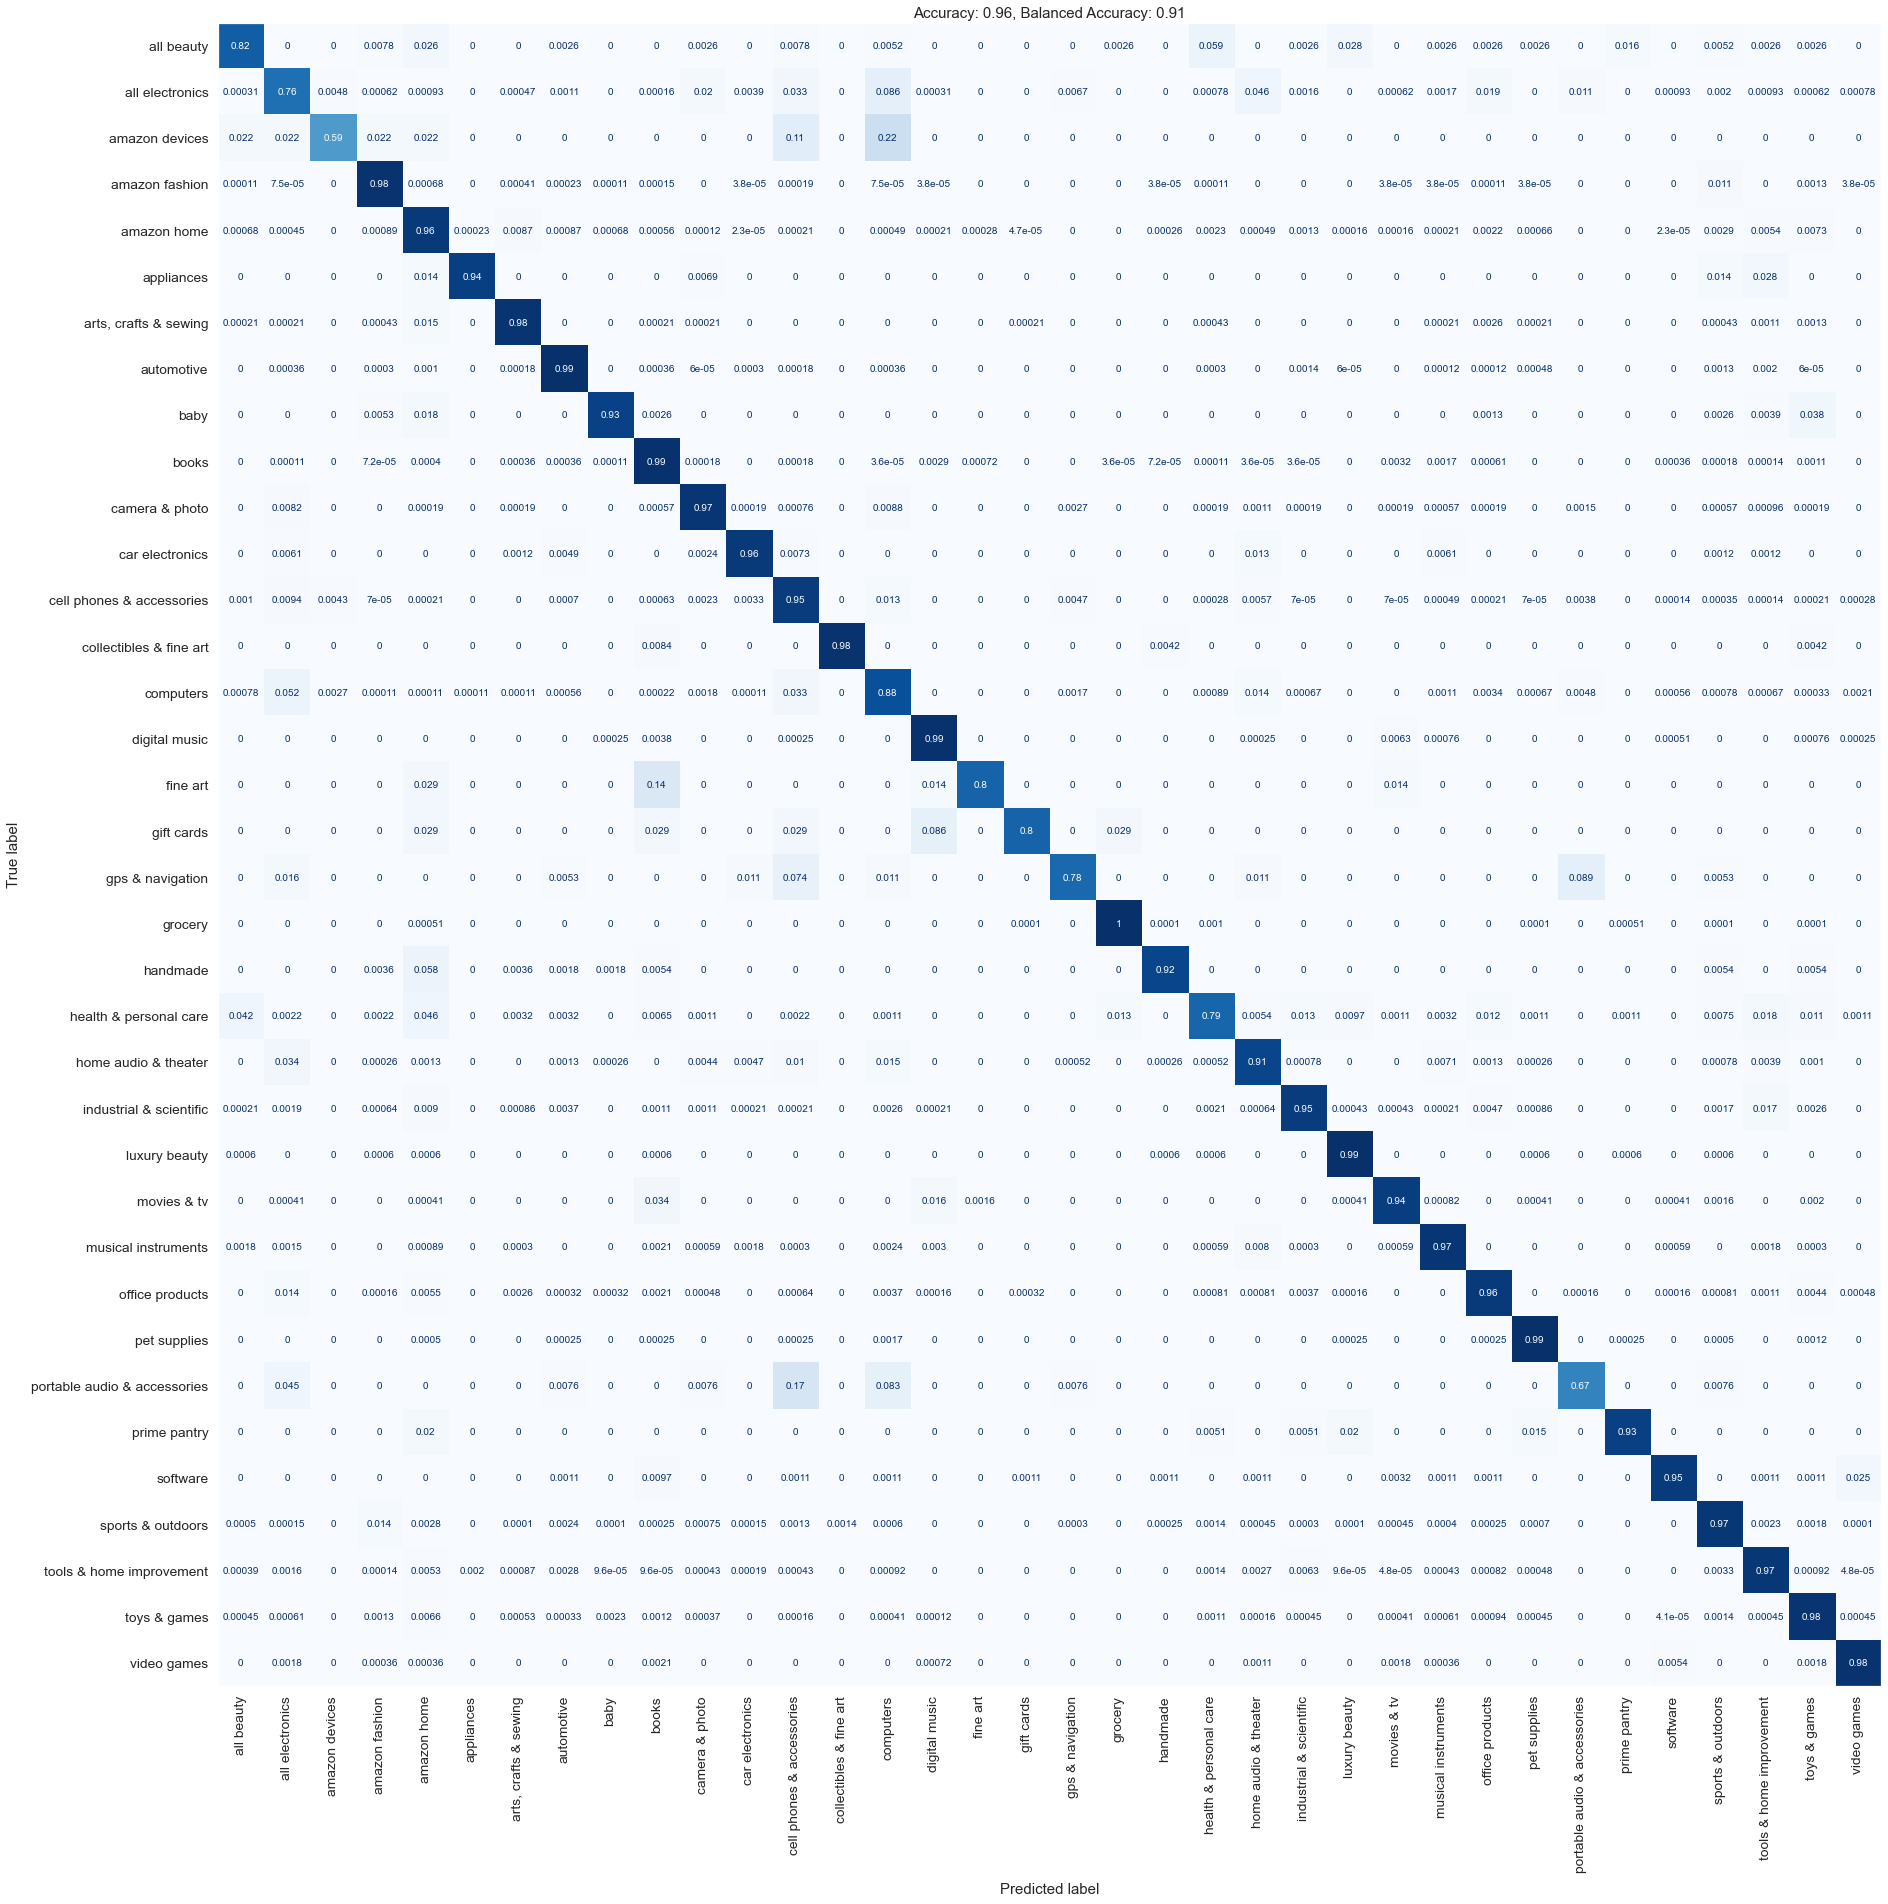

<IPython.core.display.Javascript object>

In [83]:
plot_confusion_matrix(pipe, dst="figures/svm_2_cm.svg")

It looks like 'amazon devices' and 'portable audio & accessories' have the lowest recall. Amazon doesn't need this classifier for it's own proprietary devices, but 'portable audio' could be better. It's confused with 'cell phones & accessories' about 14% of the time.

Anyway, my focus is on overall accuracy, and I'm not interested in boosting the recall of small classes at the expense of large ones.

In [84]:
coef = extract_coef(pipe)
coef.sort_values("video games", ascending=False).head(10)

all beauty  all electronics  amazon devices  amazon fashion  \
cta_digital        0.000000        -1.544874       -0.106037       -0.182259   
activision         0.000000        -0.412954       -0.039900       -0.124945   
electronic_arts    0.000000        -0.249129        0.000000       -0.205511   
mad_catz           0.000000        -2.100931       -0.063326        0.000000   
ubisoft            0.000000        -0.174991       -0.051661       -0.238391   
atari              0.000000        -0.258573        0.000000       -0.086140   
nintendo          -0.435857        -1.198789       -1.209829       -0.462205   
thq               -0.087708        -0.178751       -0.017484        0.000000   
sega               0.000000        -0.473691        0.000000       -0.069936   
sony              -0.652183         0.945628       -1.306150       -0.349223   

                 amazon home  appliances  arts, crafts & sewing  automotive  \
cta_digital        -0.785255    0.000000              -0.062472   -0.516518   
activision         -0.227798   -0.023712               0.000000   -0.226012   
electronic_arts    -0.696196    0.000000               0.000000   -0.430847   
mad_catz           -0.146762   -0.046801               0.000000   -0.133605   
ubisoft            -0.199343    0.000000              -0.060136   -0.318520   
atari              -0.041062    0.000000              -0.055139   -0.158983   
nintendo           -0.494124   -0.049790              -0.238836   -0.382382   
thq                 0.000000    0.000000               0.000000   -0.347560   
sega               -0.068049   -0.047048              -0.171130    0.150439   
sony               -1.500289   -0.142507              -0.244259   -1.315657   

                     baby     books  ...  musical instruments  \
cta_digital     -0.114832  0.000000  ...            -0.423038   
activision      -0.055396 -2.410339  ...            -0.314482   
electronic_arts -0.025292 -2.116070  ...             0.000000   
mad_catz        -0.062200  0.000000  ...            -1.916162   
ubisoft         -0.039198 -2.156084  ...            -0.266348   
atari           -0.046925 -1.392707  ...             0.000000   
nintendo        -0.124717 -1.313134  ...            -0.725768   
thq              0.000000 -1.724509  ...            -0.298590   
sega            -0.044313 -1.589803  ...            -0.139964   
sony            -0.464903 -2.141019  ...            -3.191101   

                 office products  pet supplies  portable audio & accessories  \
cta_digital            -0.122115     -0.128726                     -0.185521   
activision             -0.093605     -0.494359                      0.000000   
electronic_arts        -0.232255     -0.700725                     -0.048353   
mad_catz                0.000000      0.000000                     -0.127395   
ubisoft                -0.331200     -0.128472                     -0.022200   
atari                   0.000000      0.000000                      0.000000   
nintendo               -0.806513     -0.239310                     -0.569322   
thq                    -0.078473     -0.603640                     -0.021358   
sega                   -0.099695      0.000000                      0.000000   
sony                   -0.665023     -0.003693                     10.979919   

                 prime pantry  software  sports & outdoors  \
cta_digital          0.000000  0.000000          -2.222335   
activision          -0.032208 -2.216033          -2.191670   
electronic_arts     -0.031987 -2.383029          -2.174650   
mad_catz             0.000000 -0.107882          -1.135789   
ubisoft             -0.038783 -3.056106          -0.719240   
atari                0.000000 -2.657957          -0.979209   
nintendo            -0.037399 -1.221452          -1.638953   
thq                  0.000000 -1.135774          -0.573822   
sega                -0.040133 -0.186661          -1.330826   
sony                -0.091410  2.341329          

<IPython.core.display.Javascript object>

Another successful coefficient sanity check. Nearly all of the top features for video games are recognizable brand names.

## Optimizing the Learning Rate

Next I'll optimize the learning rate for stochastic gradient descent. The default is 'optimal', which is a function of $\alpha$, the current time step $t$, and a heuristic value $t_0$.

The other options I'll try are 'constant' and 'adaptive'. As the name suggests, 'constant' is just the constant $eta_0$, which is passed as a hyperparameter. For 'adaptive', the initial learning rate is $eta_0$, but when the stopping criterion is reached, the learning rate is divided by 5 and the descent continues (defying the gods). The descent doesn't stop until the learning rate goes below $10^{-6}$.

In [85]:
learn_grid = [
    {
        "learning_rate": ["constant", "adaptive"],
        "eta0": sp.stats.loguniform(1e-4, 1e4),
        "average": [True, False],
    },
    {
        "learning_rate": ["optimal"],
        "average": [True, False],
    },
]
learn_grid

[{'learning_rate': ['constant', 'adaptive'],
  'eta0': <scipy.stats._distn_infrastructure.rv_frozen at 0x257dcbe8280>,
  'average': [True, False]},
 {'learning_rate': ['optimal'], 'average': [True, False]}]

<IPython.core.display.Javascript object>

In [86]:
if "learn" in RUN_SWEEPS:
    gs = selection.sweep(
        pipe,
        learn_grid,
        X=X_train,
        y=y_train,
        cv_dst="sweeps/learn_cv.joblib",
        kind="hrand",
        add_prefix="cls__",
        min_resources=10 ** 4,
        max_resources=X_train.shape[0],
        n_jobs=-1,
        factor=3,
    )
    learn_results = gs.cv_results_
else:
    learn_results = joblib.load("sweeps/learn_cv.joblib")

learn_results = selection.prune_cv(learn_results)
learn_results.head(10)

average      eta0 learning_rate  \
0     True  0.841666      adaptive   
1     True  0.841666      adaptive   
2    False  1.656650      adaptive   
3    False  0.857235      constant   
4     True  0.841666      adaptive   
5    False  1.656650      adaptive   
6    False  0.857235      constant   
7    False  1.925135      adaptive   
8    False  0.086955      constant   
9    False  0.081826      constant   

                                              params  mean_fit_time  \
0  {'cls__average': True, 'cls__eta0': 0.84166636...    2718.412539   
1  {'cls__average': True, 'cls__eta0': 0.84166636...     971.841199   
2  {'cls__average': False, 'cls__eta0': 1.6566501...     362.309605   
3  {'cls__average': False, 'cls__eta0': 0.8572352...      85.645006   
4  {'cls__average': True, 'cls__eta0': 0.84166636...     289.311396   
5  {'cls__average': False, 'cls__eta0': 1.6566501...     117.517600   
6  {'cls__average': False, 'cls__eta0': 0.8572352...      36.053796   
7  {'cls__average': False, 'cls__eta0': 1.9251349...     116.465399   
8  {'cls__average': False, 'cls__eta0': 0.0869545...      26.184200   
9  {'cls__average': False, 'cls__eta0': 0.0818255...      87.510197   

   mean_score  rank_score  
0    0.964341           1  
1    0.954659           2  
2    0.954233           3  
3    0.952689           4  
4    0.938111           5  
5    0.937444           6  
6    0.937389           7  
7    0.936867           8  
8    0.935878           9  
9    0.935878           9

<IPython.core.display.Javascript object>

Looks like 'adaptive' wins, and with an epic fit time. The long fit time makes sense given the unyielding nature of the algorithm.

## Fitting the Final Model

Time to fit the third and final version of the model, now with 'adaptive' learning rate.

In [87]:
learn_params = learn_results.loc[0, "params"]
display(learn_params)
pipe.set_params(**learn_params)

{'cls__average': True,
 'cls__eta0': 0.8416663608926325,
 'cls__learning_rate': 'adaptive'}

Pipeline(steps=[('vec',
                 TfidfVectorizer(binary=True, lowercase=False,
                                 token_pattern='(?i)\\b[a-z_]{2,16}\\b')),
                ('cls',
                 SGDClassifier(alpha=5.25503769545935e-07, average=True,
                               class_weight='balanced', eta0=0.8416663608926325,
                               learning_rate='adaptive', n_jobs=-1))],
         verbose=True)

<IPython.core.display.Javascript object>

In [19]:
if "svm_3" in FIT_MODELS:
    pipe.fit(X_train, y_train)

    joblib.dump(pipe, "models/svm_3.joblib", compress=True)

else:
    pipe = joblib.load("models/svm_3.joblib")
pipe

Pipeline(steps=[('vec',
                 TfidfVectorizer(binary=True, lowercase=False,
                                 token_pattern='(?i)\\b[a-z_]{2,16}\\b')),
                ('cls',
                 SGDClassifier(alpha=5.25503769545935e-07, average=True,
                               class_weight='balanced', eta0=0.8416663608926325,
                               learning_rate='adaptive', n_jobs=-1))],
         verbose=True)

<IPython.core.display.Javascript object>

That took ~10 minutes to train, which is about 5x a long as the 'optimal' learning rate.

<AxesSubplot:title={'center':'Accuracy: 0.96, Balanced Accuracy: 0.93'}, xlabel='Predicted label', ylabel='True label'>

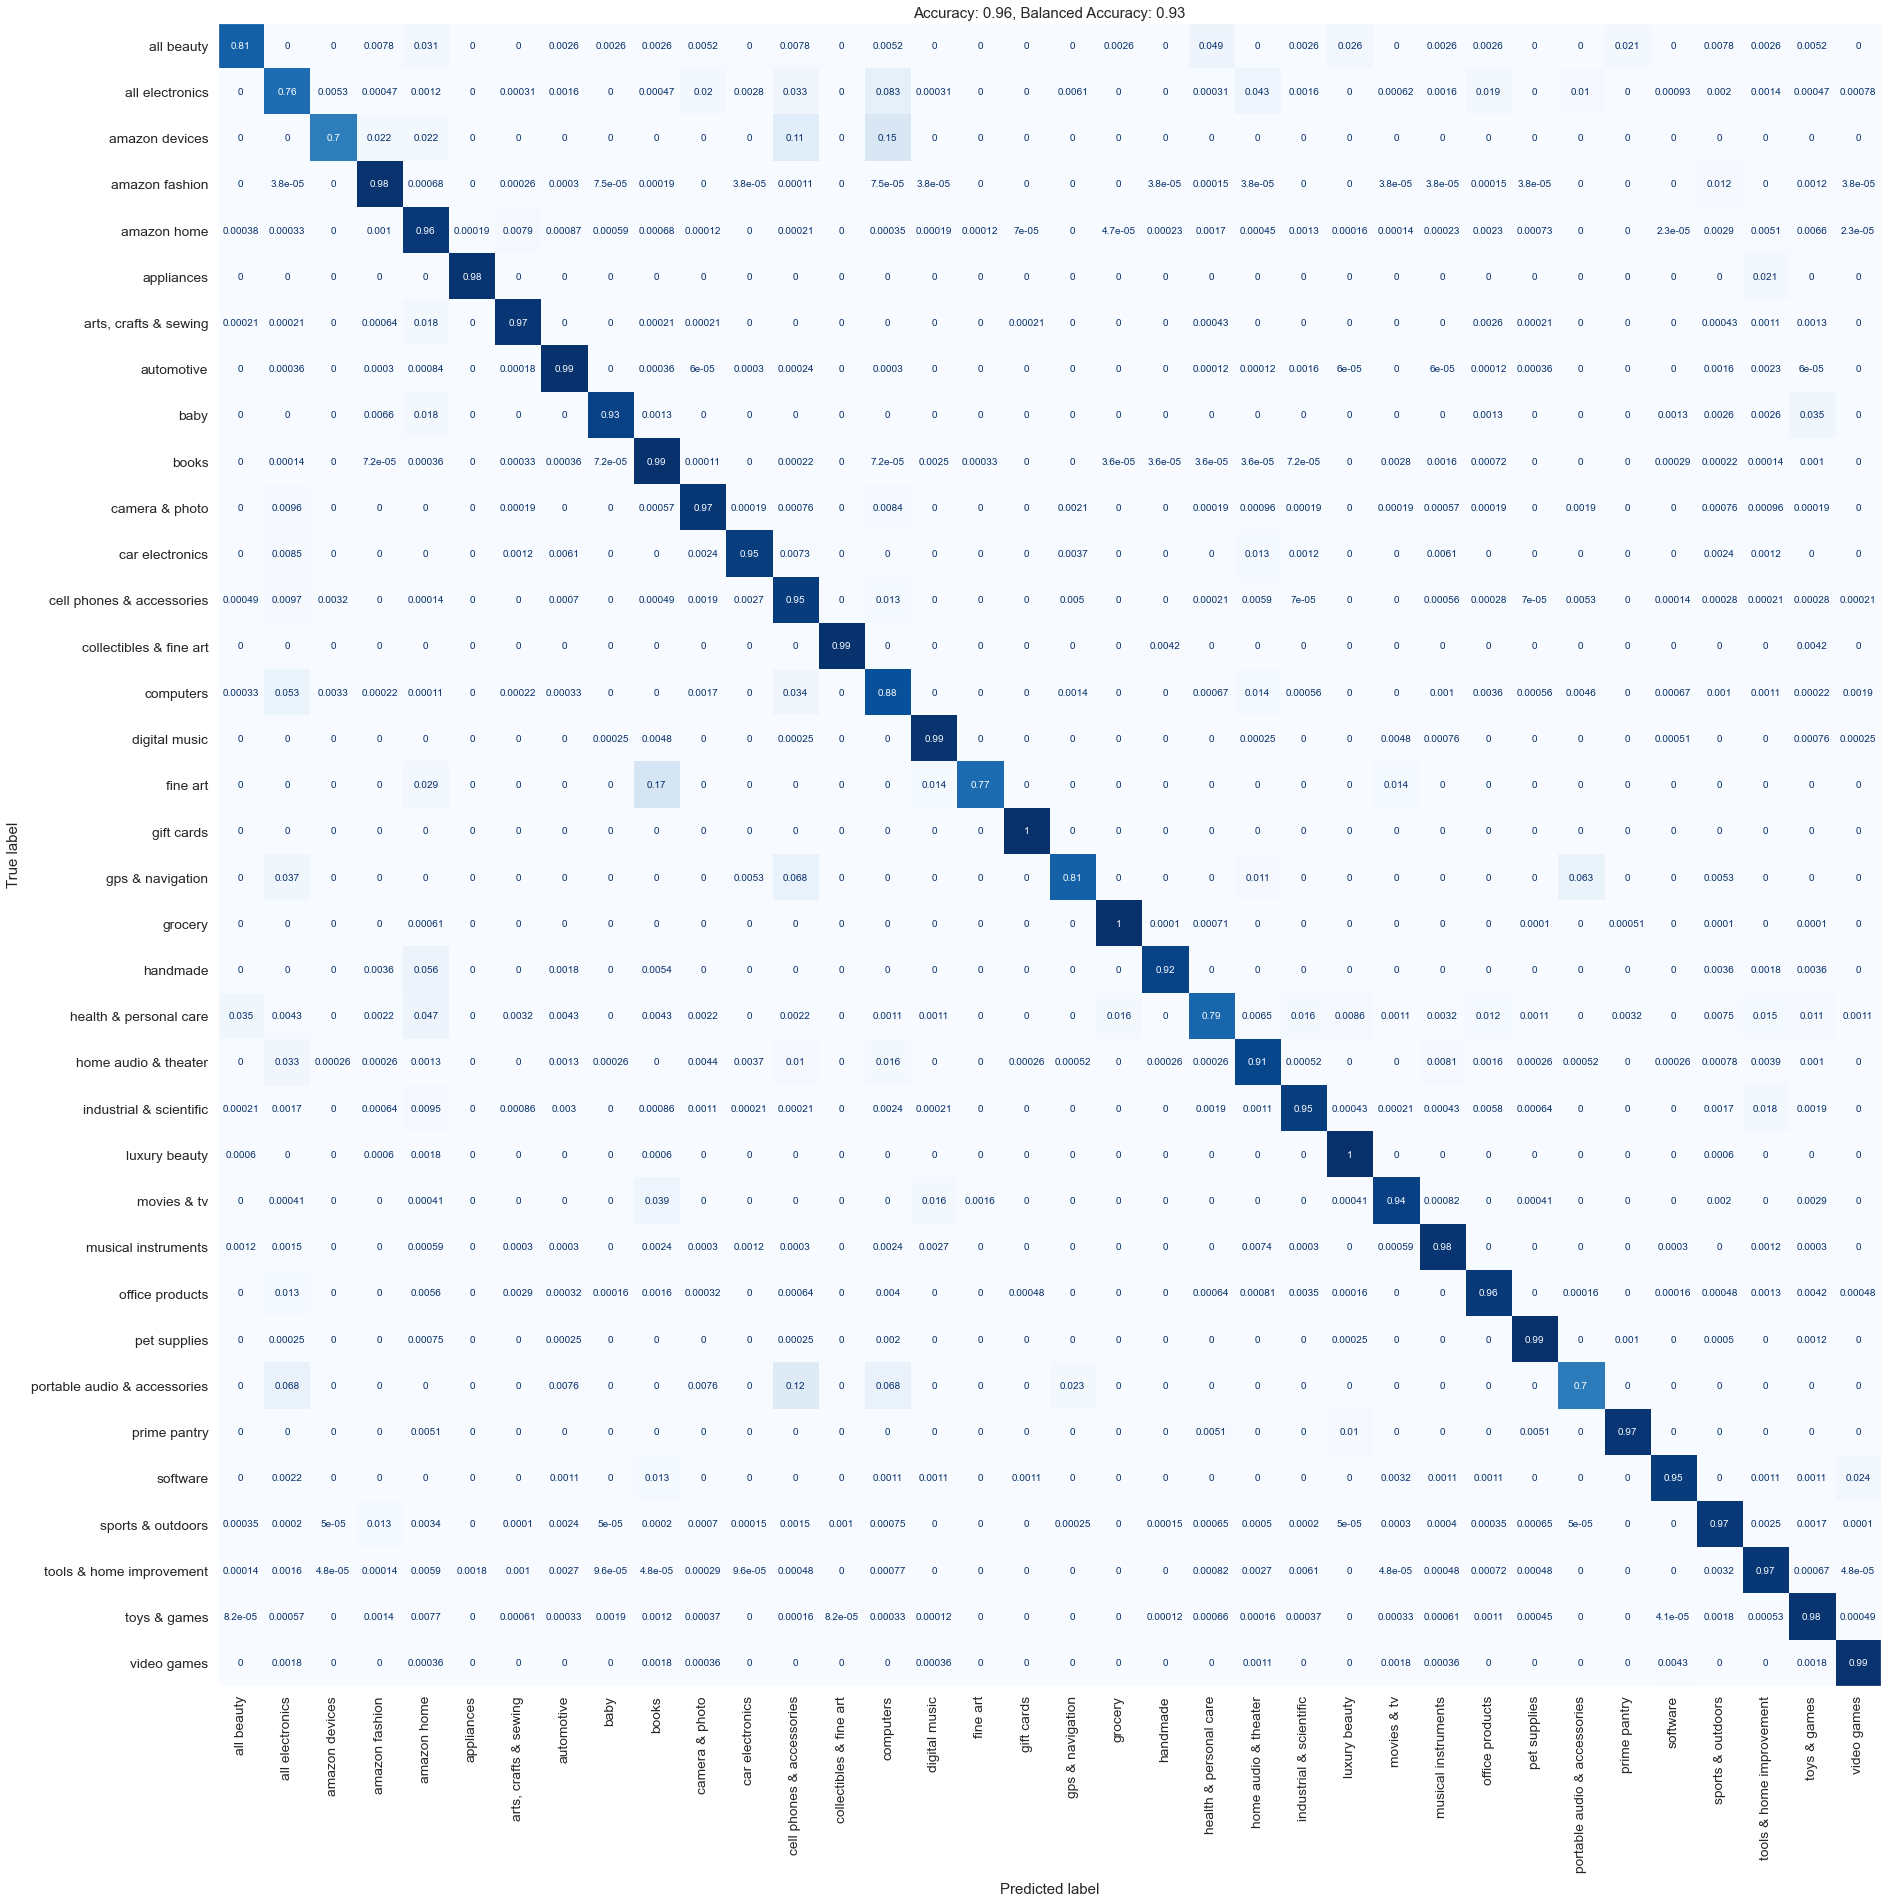

<IPython.core.display.Javascript object>

In [89]:
plot_confusion_matrix(pipe, dst="figures/svm_3_cm.svg")

It's still sitting at 0.96 accuracy, but the balanced accuracy improved slightly. 0.96 accuracy is already quite a satisfactory number, so I'll move on to interpretation.

# Interpreting the Results

The next step is to take a closer look at the final model's coefficients. I already know that brand terms are critically important, but I'd like to see which brands are associated with which categories. I'm also interested in discovering what non-brand terms made it to the top.

In [39]:
coef = extract_coef(pipe)
coef.columns = coef.columns.str.title()
coef.sort_values("Amazon Fashion", ascending=False).head(20)

All Beauty  All Electronics  Amazon Devices  Amazon Fashion  \
port_authority    -0.212596         0.009663       -0.011277        6.053034   
fun_world         -0.185282        -0.013629        0.000000        5.044107   
sport_tek          0.000000        -0.014721        0.000000        5.021977   
synthetic_sole    -0.223528        -0.073502       -0.074717        4.795533   
sk_hat_shop       -0.175141         0.000000       -0.022411        4.739004   
fun_costumes      -0.058061         0.000000       -0.061565        4.477906   
rubber_sole       -0.356188        -0.217899       -0.155645        4.268081   
clothing_shoes    -0.403733        -0.109396       -0.015496        4.090943   
peach_couture     -0.199304        -0.130758       -0.043984        4.051408   
sole_heel         -0.332170        -0.009918       -0.123003        4.029316   
greatlookz        -0.059315         0.000000       -0.004975        3.888560   
kilofly           -0.393476        -0.246614        0.000000        3.842974   
damara_womens     -1.168214        -0.163282       -0.122791        3.836949   
tobeinstyle       -0.123597         0.000000        0.000000        3.775642   
michael_kors      -0.107783        -0.276432       -0.057959        3.753046   
avalaya           -0.217298        -0.057528       -0.012006        3.741300   
harley_davidson   -0.279419        -0.477372       -0.074178        3.585215   
watch              0.130324         0.028137       -1.795667        3.489432   
casio             -0.125100         3.786088       -0.066038        3.481366   
pewter_pendant    -0.348377        -0.066640       -0.017468        3.445926   

                 Amazon Home  Appliances  Arts, Crafts & Sewing  Automotive  \
port_authority     -0.222141    0.000000              -0.101590   -0.165922   
fun_world          -1.082475    0.000000              -0.023725   -0.035658   
sport_tek          -0.056542    0.000000              -0.100879   -0.066158   
synthetic_sole     -0.802506    0.000000              -0.190685   -0.301803   
sk_hat_shop        -0.417239   -0.014362              -0.148723   -0.116165   
fun_costumes        0.000000    0.000000              -0.126520    0.000000   
rubber_sole        -0.980572   -0.008216               0.026077   -0.219809   
clothing_shoes     -1.018837    0.000000              -0.794035   -0.057783   
peach_couture      -1.434661    0.000000              -0.243469   -0.038703   
sole_heel          -0.920196   -0.011871              -0.152868   -0.032036   
greatlookz         -1.540568    0.000000              -0.400107    0.000000   
kilofly            -0.621938    0.000000              -0.180492   -0.057149   
damara_womens      -0.436998   -0.015476              -0.091956    0.000000   
tobeinstyle        -0.428391    0.000000               0.000000    0.000000   
michael_kors       -0.391496   -0.014539              -0.371675   -0.052787   
avalaya            -1.357068    0.000000              -0.862267   -0.026775   
harley_davidson     1.342547   -0.042265              -0.423487    1.455907   
watch              -0.676668   -0.437934              -0.012770   -1.256815   
casio              -0.761622   -0.114066              -0.115944   -0.085454   
pewter_pendant     -1.039632    0.000000              -0.741076   -0.020912   

                     Baby     Books  ...  Musical Instruments  \
port_authority  -0.073788 -0.055549  ...             0.000000   
fun_world       -0.291685  0.002296  ...            -0.057048   
sport_tek        0.000000 -0.082672  ...            -0.018885   
synthetic_sole  -0.290958 -0.522018  ...            -0.040949   
sk_hat_shop     -0.120623 -0.092172  ...             0.000000   
fun_costumes    -0.392929 -0.594827  ...             0.000000   
rubber_sole     -0.405376 -0.998909  ...            -0.040592   
clothing_shoes  -0.440984 -0.646910  ...             0.000000   
peach_couture   -0.161027 -0.101177  ...            -0.054348   
sole_heel       -0.328577 

<IPython.core.display.Javascript object>

I definitely recognize some of these fashion brands, like Harley Davidson.

Since there are 36 categories and ~490K terms, it's difficult to get a view of the big picture. In order to get a birds-eye-view, I'm going to plot a small wordcloud for each category.

I prepare some colormaps in the following cell.

In [40]:
rng = np.random.default_rng(1594)

cmaps = [
    "Purples",
    "Blues",
    "Greens",
    "Oranges",
    "Reds",
    "YlOrBr",
    "YlOrRd",
    "OrRd",
    "PuRd",
    "RdPu",
    "BuPu",
    "GnBu",
    "PuBu",
    "YlGnBu",
    "PuBuGn",
    "BuGn",
    "YlGn",
]
rng.shuffle(cmaps)
cmaps

['Purples',
 'Greens',
 'BuGn',
 'YlGn',
 'GnBu',
 'RdPu',
 'YlOrRd',
 'BuPu',
 'PuBu',
 'PuRd',
 'Reds',
 'YlGnBu',
 'Oranges',
 'Blues',
 'PuBuGn',
 'OrRd',
 'YlOrBr']

<IPython.core.display.Javascript object>

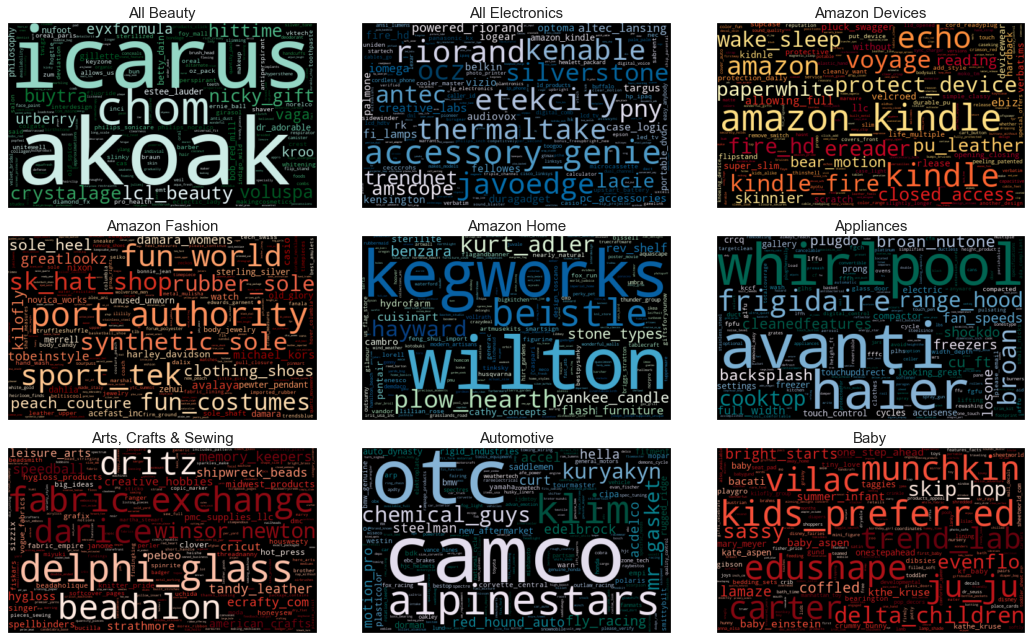

<IPython.core.display.Javascript object>

In [41]:
fig = plotting.wordcloud(
    coef.iloc[:, :9],
    cmap=rng.choice(cmaps, 9).tolist(),
)
fig.savefig("figures/coef_birdseye_1.svg")

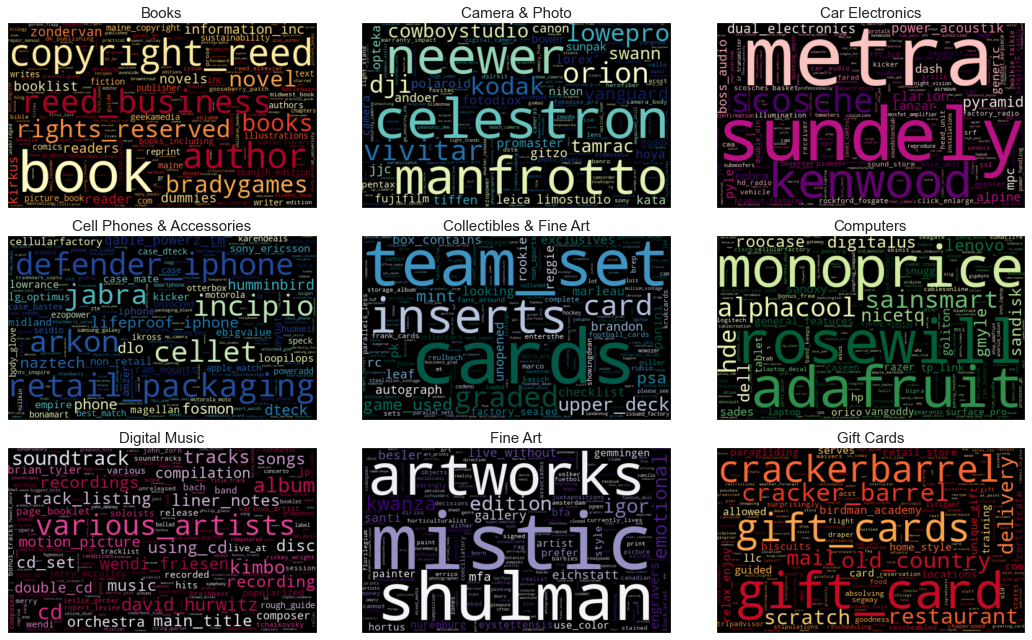

<IPython.core.display.Javascript object>

In [42]:
fig = plotting.wordcloud(
    coef.iloc[:, 9:18],
    cmap=rng.choice(cmaps, 9).tolist(),
)
fig.savefig("figures/coef_birdseye_2.svg")

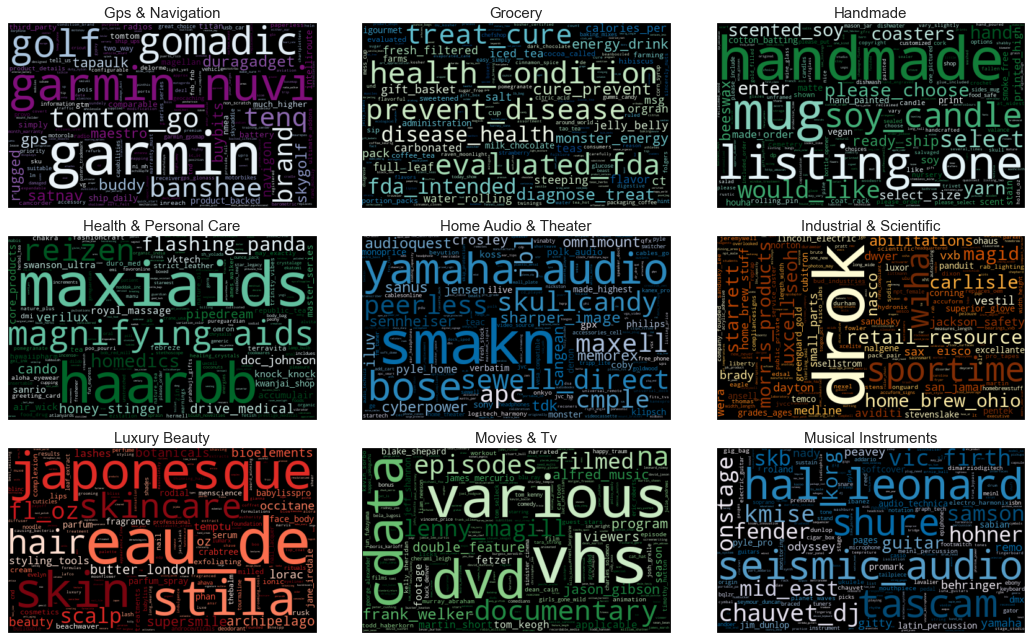

<IPython.core.display.Javascript object>

In [43]:
fig = plotting.wordcloud(
    coef.iloc[:, 18:27],
    cmap=rng.choice(cmaps, 9).tolist(),
)
fig.savefig("figures/coef_birdseye_3.svg")

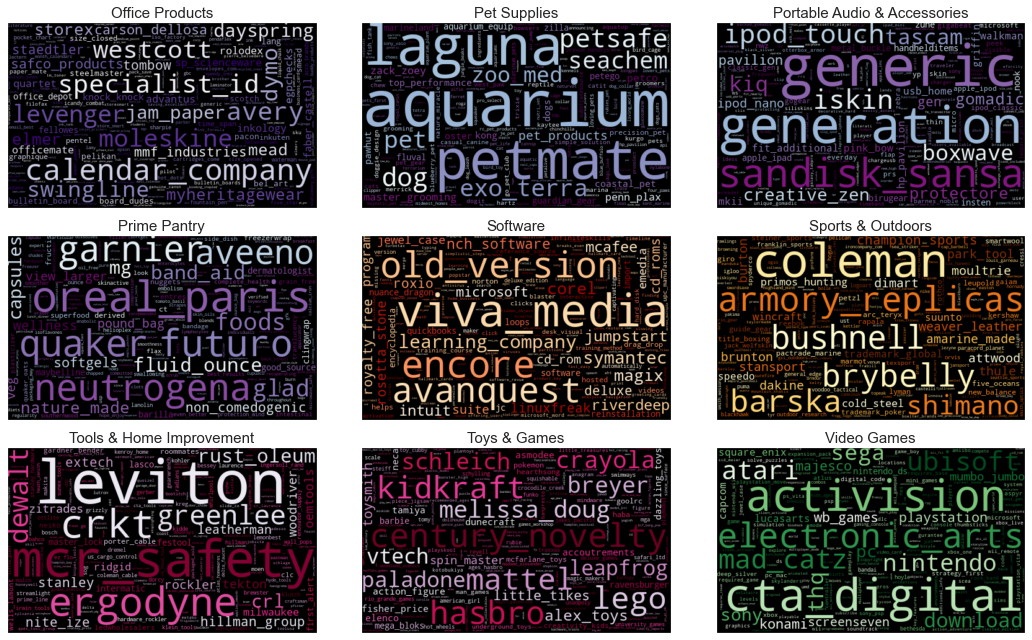

<IPython.core.display.Javascript object>

In [44]:
fig = plotting.wordcloud(
    coef.iloc[:, 27:36],
    cmap=rng.choice(cmaps, 9).tolist(),
)
fig.savefig("figures/coef_birdseye_4.svg")

# Conclusion

I developed a highly accurate multi-class classifier on an a dataset with 36-classes. One reason for the model's high score is that I selected a very high quality dataset. Amazon product data is both plentiful and well-labeled. The human-given category labels are themselves highly accurate, unlike the crowdsourced Twitter dataset I last worked with. Why? Because on Amazon, people's livelihoods are on the line (including Amazon's). It matters to sellers how they classify their products, and it matters to you too. Classification matters to businesses because it matters to customers&mdash;it can determine whether a customer buys a product or never even hears about it.

#### If you're looking to classify products with NLP, lead with the brand terms.

Brand terms ranked high in nearly every category. One could build a decent model with *only* brand terms, though I wouldn't recommend going that far. Even if you wanted an image-based classifier, brands are the first place I'd start. 

#### Develop brand classifiers to improve your brand data.

I selected only the top 1% of brands from each category (with some exceptions). The bottom 99% is loaded with one-off brands, many of which seem sloppily labeled. Perhaps you could create brand classifiers for each category.

#### Use the model to study your competitors and scope out new suppliers.

This model can be used to analyze other business' inventories, including those of competitors. Discover new products and suppliers by directly comparing their inventories to yours under your classification scheme. See how their classification differs from yours by examining how the categories line up.

# Looking Forward

- Gather data on brands concerning their relationships and parent companies.
- Develop a workflow to create specialized subcategory models for each major category.
    - These will be **multilabel** classification models.
- Create a dashboard to demonstrate the accuracy and rich interpretability of the model.
- Obtain a new, unseen dataset to test the model's generalizability.